In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

In [36]:
# # Create a directed graph
# G1 = nx.DiGraph()
# G2 = nx.DiGraph()

# # Assume 'Title' column holds the video titles; adjust if your column names differ
# for i in range(len(df1) - 1):
#     G1.add_edge(df1.iloc[i]['Channel'], df1.iloc[i+1]['Channel'])

# for i in range(len(df2) - 1):
#     G2.add_edge(df2.iloc[i]['Channel'], df2.iloc[i+1]['Channel'])

# # Assuming df_run1 and df_run2 are already loaded and G1, G2 are created

# # Combine both graphs for the layout calculation
# combined_graph = nx.compose(G1, G2)

# # Generate a layout based on all nodes in the combined graph
# pos = nx.spring_layout(combined_graph)

# # Now draw the graphs using the combined layout
# plt.figure(figsize=(15, 15))
# nx.draw_networkx_nodes(G1, pos, node_size=700, node_color='skyblue', alpha=0.6)
# nx.draw_networkx_edges(G1, pos, edge_color='blue', style='solid')
# nx.draw_networkx_labels(G1, pos, font_color='black')

# nx.draw_networkx_nodes(G2, pos, node_size=500, node_color='lightgreen', alpha=0.7)
# nx.draw_networkx_edges(G2, pos, edge_color='green', style='dashed')
# nx.draw_networkx_labels(G2, pos, font_color='black')

# plt.title('Comparison of YouTube Recommendation Paths in Two Different Runs')
# plt.axis('off')
# plt.show()


# Gun-Type

In [354]:

# Define the path and the file names
#base_path = 'C:/Users/User/Documents/GitHub/ans-project/select_runs/'
base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/'
runs = ['run28.csv', 'run44.csv', 'run46.csv', 'run47.csv', 'run48.csv']

# Create a dictionary to hold the dataframes
dfs = {}

# Load each file into the dictionary
for run in runs:
    run_number = run.split('.')[0]  # This will extract the part of the filename without '.csv'
    dfs[run_number] = pd.read_csv(base_path + run)

# Optionally process each dataframe
for df_key in dfs:
    dfs[df_key] = dfs[df_key].drop_duplicates()

# To access and work with a specific dataframe, you can do it by its key:
dfs['run28'].head()

,Unnamed: 0,Title,Channel,url,video_list,Training
0,0,Diddler Gets Shot In The Dingaling!,Donut Operator,https://www.youtube.com/watch?v=63twaXPVfs4,Gun-type,True
1,1,Cop Vs. Katana Wielding Neckbeard,Donut Operator,https://www.youtube.com/watch?v=xHYIPhfj8E8,Gun-type,True
2,2,Why U.S Military Drills Freak Out North Korea,Task & Purpose,https://www.youtube.com/watch?v=7cS9H7FUpf0,Gun-type,True
3,3,Russian Tactical Nuke Exercise - War Map Compa...,Preston Stewart,https://www.youtube.com/watch?v=4VgQ-3MJ3TI,Gun-type,True
4,4,IDF Begins Major Operation in Southern Gaza - ...,Preston Stewart,https://www.youtube.com/watch?v=KLo6CZp-PUs,Gun-type,True


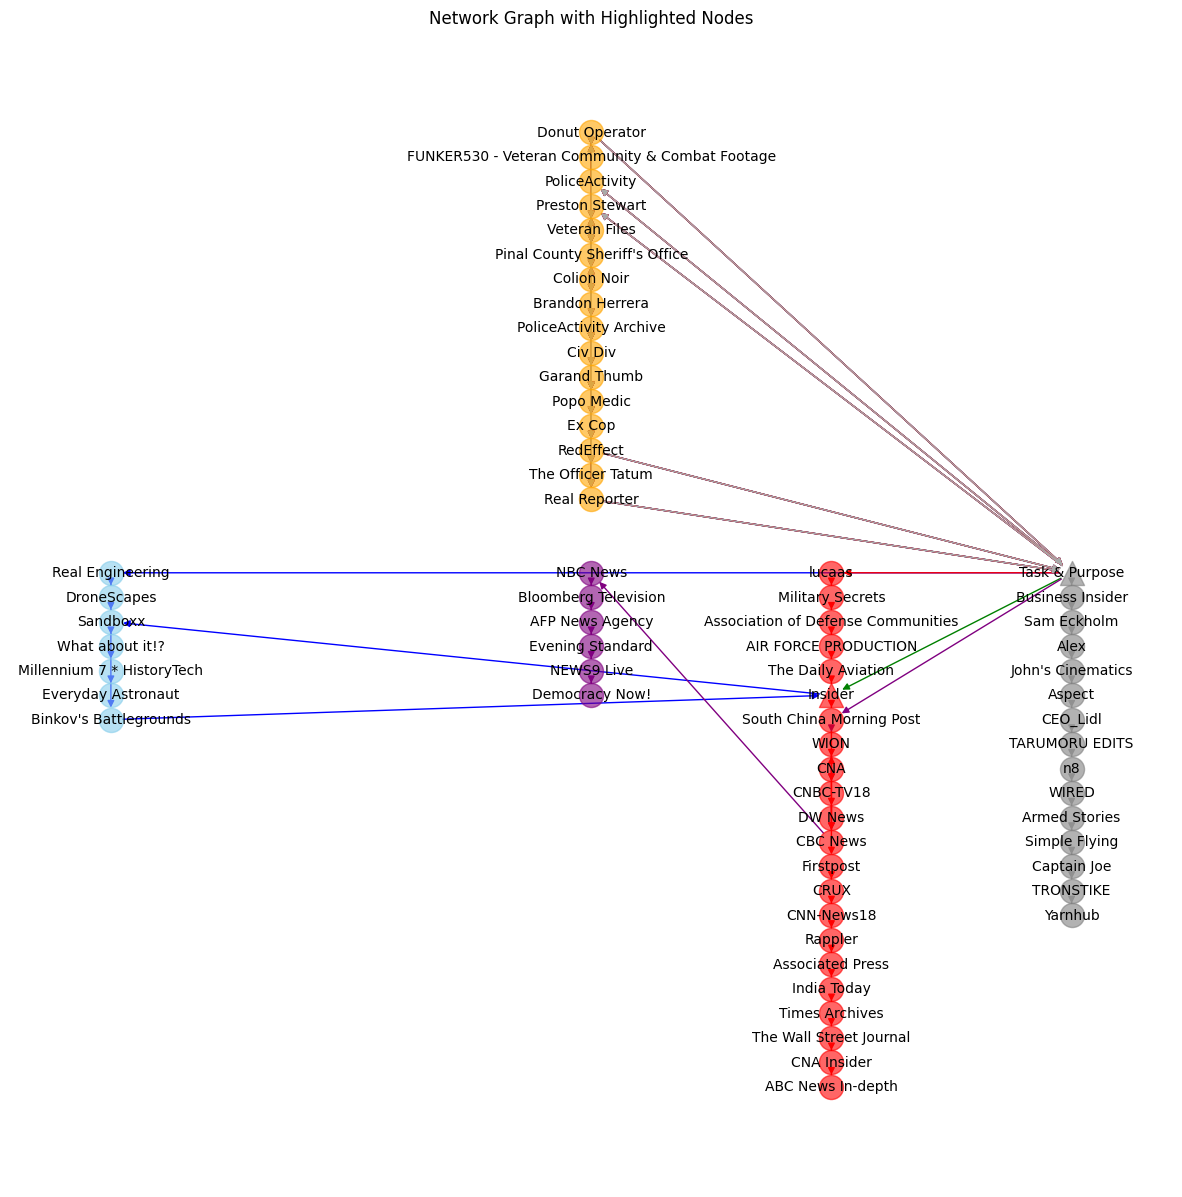

In [355]:

graphs = {}
layer_mapping = {key: i for i, key in enumerate(dfs.keys())}

# Create graphs for each DataFrame, avoiding self-loops and assigning initial layers
for key, df in dfs.items():
    G = nx.DiGraph()
    current_layer = layer_mapping[key]
    for i in range(len(df) - 1):
        src = df.iloc[i]['Channel']
        tgt = df.iloc[i + 1]['Channel']
        if src != tgt:
            G.add_node(src, Training=df.iloc[i]['Training'], layer=current_layer)
            G.add_node(tgt, Training=df.iloc[i + 1]['Training'], layer=current_layer)
            G.add_edge(src, tgt)
    graphs[key] = G

# Combine all individual graphs into a single graph
combined_graph = nx.compose_all(graphs.values())

# Calculate the median layer to position 'Training' nodes
total_layers = list(layer_mapping.values())
median_layer = ceil(np.median(total_layers))

# Update the layer for nodes where 'Training' is True to the median layer
for node, data in combined_graph.nodes(data=True):
    if data.get('Training'):
        data['layer'] = median_layer

# Apply a hierarchical layout using 'dot'
pos = graphviz_layout(combined_graph, prog='dot')

# Spread nodes in the same adjusted layer horizontally to emphasize parallel paths
layers = {}

for node, data in combined_graph.nodes(data=True):
    layer = data['layer']
    if layer not in layers:
        layers[layer] = []
    layers[layer].append(node)

for layer, nodes in layers.items():
    for i, node in enumerate(nodes):
        pos[node] = (layer * 100, pos[node][1] )  


minimum_distance=100
# Sorting nodes in each layer by their y-position and adjusting positions if too close
for layer, nodes in layers.items():
    sorted_nodes = sorted(nodes, key=lambda n: pos[n][1])
    for i in range(1, len(sorted_nodes)):
        current_pos = pos[sorted_nodes[i]][1]
        previous_pos = pos[sorted_nodes[i - 1]][1]
        if current_pos - previous_pos < minimum_distance:
            pos[sorted_nodes[i]] = (pos[sorted_nodes[i]][0], previous_pos + minimum_distance)

# First pass to find the lowest y-position of training nodes across all layers
min_y_for_training = float('inf')
for node, data in combined_graph.nodes(data=True):
    if data['Training'] and pos[node][1] < min_y_for_training:
        min_y_for_training = pos[node][1]

# Second pass to adjust y-positions for non-training nodes
adjustment = {}
for node, data in combined_graph.nodes(data=True):
    if not data['Training']:
        layer = data['layer']
        if layer not in adjustment:
            # Find the highest y-position of non-training nodes in the same layer
            max_y_in_layer = max(pos[n][1] for n in combined_graph.nodes if combined_graph.nodes[n]['layer'] == layer and not combined_graph.nodes[n]['Training'])
            adjustment[layer] = min_y_for_training-300 - max_y_in_layer
        # Apply adjustment
        pos[node] = (pos[node][0], pos[node][1] + adjustment[layer])


# Indegree calculation
indegree_map = dict(combined_graph.in_degree())

# Shapes for different indegrees
shapes = [ '','o','^', 's', 'p', '*', 'h', 'H', 'D', 'd', '|', '_']
# Mapping indegrees to shapes dynamically
unique_indegrees = sorted(set(indegree_map.values()))
indegree_to_shape = {deg: shapes[i % len(shapes)] for i, deg in enumerate(unique_indegrees) if deg > 1}

# Assign shapes based on indegree
node_shapes = {node: indegree_to_shape.get(indegree, 'o') for node, indegree in indegree_map.items()}


plt.figure(figsize=(15, 15))
colors = ['skyblue', 'lightgreen', 'purple', 'red', 'grey', 'pink', 'brown']
edge_colors = ['blue', 'green', 'purple', 'red', 'darkgrey', 'pink', 'brown']


# Draw all nodes first
for node in combined_graph.nodes():
    node_data = combined_graph.nodes[node]
    color = 'orange' if node_data['Training'] else colors[node_data['layer'] % len(colors)]
    shape = node_shapes[node]
    nx.draw_networkx_nodes(combined_graph, pos, nodelist=[node], node_color=color, node_shape=shape, node_size=300, alpha=0.6)

# Draw the graphs, separating calls by node shape
for i, (key, graph) in enumerate(graphs.items()):
    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors[i], style='solid', arrows=True)


# Draw edges
nx.draw_networkx_labels(combined_graph, pos, font_color='black', font_size=10)

plt.title('Network Graph with Highlighted Nodes')
plt.axis('off')
plt.show()


## Left

In [352]:

# Define the path and the file names
base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/'
runs = ['run32.csv', 'run58.csv', 'run59.csv', 'run60.csv']

# Create a dictionary to hold the dataframes
dfs = {}

# Load each file into the dictionary
for run in runs:
    run_number = run.split('.')[0]  # This will extract the part of the filename without '.csv'
    dfs[run_number] = pd.read_csv(base_path + run)

# Optionally process each dataframe
for df_key in dfs:
    dfs[df_key] = dfs[df_key].drop_duplicates()

# To access and work with a specific dataframe, you can do it by its key:
dfs['run32'].head()

,Unnamed: 0,Title,Channel,url,video_list,Training
0,0,"Rechtsextremismus, Managerlöhne, Wahlwochenend...",SP Schweiz,https://www.youtube.com/watch?v=Rqc4N84Hb1M,Left,True
1,1,Klimaseniorin Elisabeth Joris: Vom Gemeinschaf...,SP Schweiz,https://www.youtube.com/watch?v=ttMms0xNlUU,Left,True
2,2,Prämieninitiative: Ruth Dreifuss im Gespräch |...,SP Schweiz,https://www.youtube.com/watch?v=qlpauE4ANqs,Left,True
3,3,"Klimaseniorinnen, Vetternwirtschaft in Genf, D...",Nebelspalter,https://www.youtube.com/watch?v=BTHgGr1Z2m8,Left,True
4,4,"Krawalle, Familiennachzug, fliegende Bundesrät...",Nebelspalter,https://www.youtube.com/watch?v=KQeaIaoMh9Y,Left,True


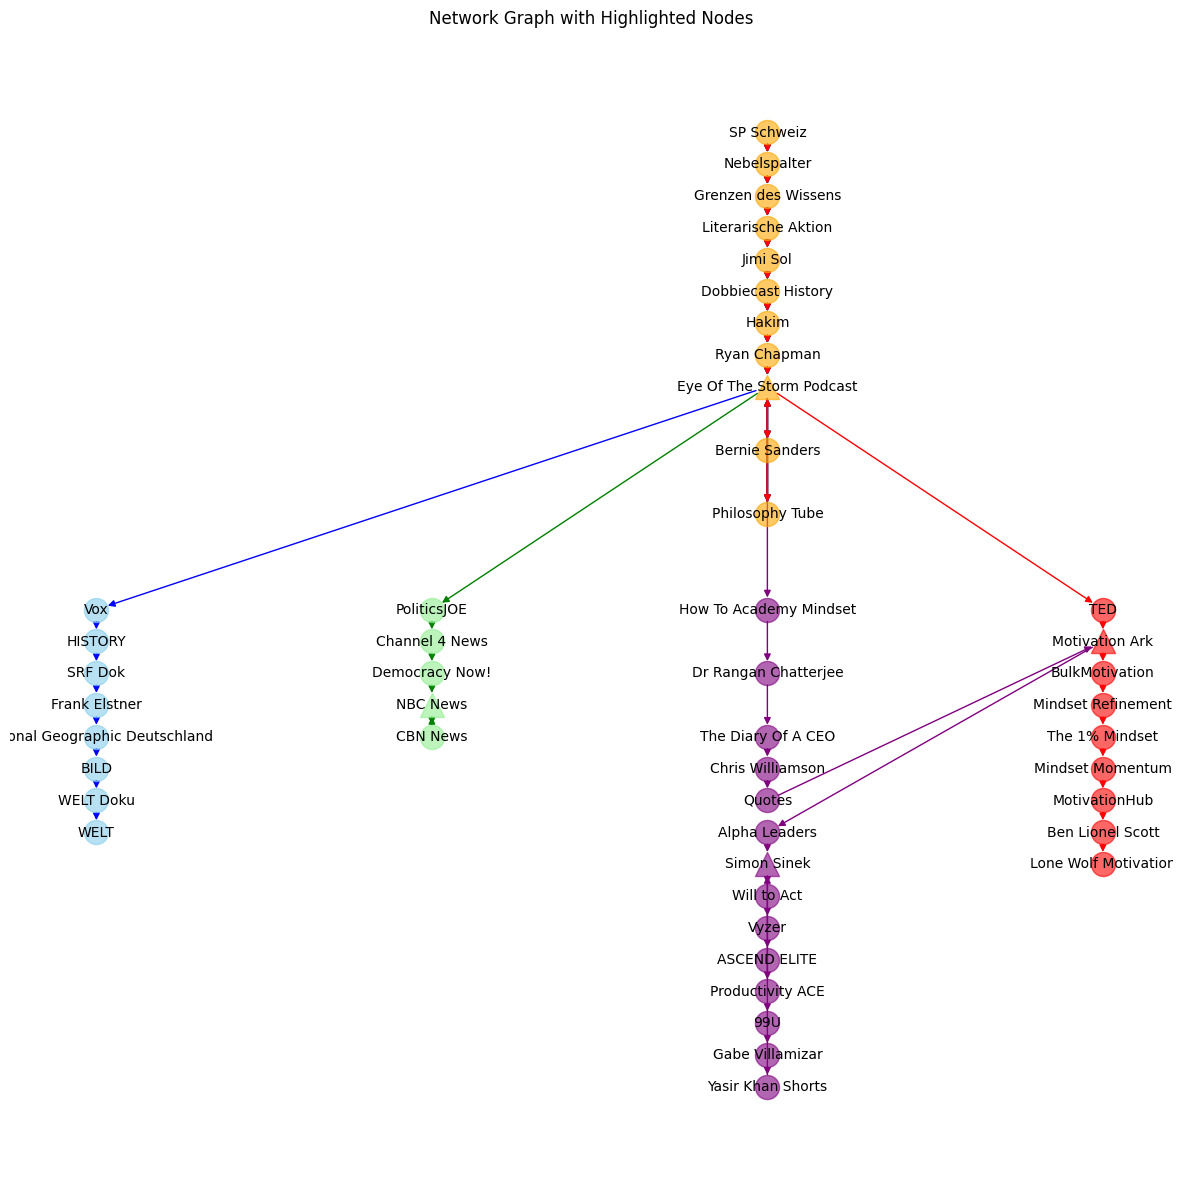

In [353]:

graphs = {}
layer_mapping = {key: i for i, key in enumerate(dfs.keys())}

# Create graphs for each DataFrame, avoiding self-loops and assigning initial layers
for key, df in dfs.items():
    G = nx.DiGraph()
    current_layer = layer_mapping[key]
    for i in range(len(df) - 1):
        src = df.iloc[i]['Channel']
        tgt = df.iloc[i + 1]['Channel']
        if src != tgt:
            G.add_node(src, Training=df.iloc[i]['Training'], layer=current_layer)
            G.add_node(tgt, Training=df.iloc[i + 1]['Training'], layer=current_layer)
            G.add_edge(src, tgt)
    graphs[key] = G

# Combine all individual graphs into a single graph
combined_graph = nx.compose_all(graphs.values())

# Calculate the median layer to position 'Training' nodes
total_layers = list(layer_mapping.values())
median_layer = ceil(np.median(total_layers))

# Update the layer for nodes where 'Training' is True to the median layer
for node, data in combined_graph.nodes(data=True):
    if data.get('Training'):
        data['layer'] = median_layer

# Apply a hierarchical layout using 'dot'
pos = graphviz_layout(combined_graph, prog='dot')

# Spread nodes in the same adjusted layer horizontally to emphasize parallel paths
layers = {}

for node, data in combined_graph.nodes(data=True):
    layer = data['layer']
    if layer not in layers:
        layers[layer] = []
    layers[layer].append(node)

for layer, nodes in layers.items():
    for i, node in enumerate(nodes):
        pos[node] = (layer * 100, pos[node][1] )  


minimum_distance=100
# Sorting nodes in each layer by their y-position and adjusting positions if too close
for layer, nodes in layers.items():
    sorted_nodes = sorted(nodes, key=lambda n: pos[n][1])
    for i in range(1, len(sorted_nodes)):
        current_pos = pos[sorted_nodes[i]][1]
        previous_pos = pos[sorted_nodes[i - 1]][1]
        if current_pos - previous_pos < minimum_distance:
            pos[sorted_nodes[i]] = (pos[sorted_nodes[i]][0], previous_pos + minimum_distance)

# First pass to find the lowest y-position of training nodes across all layers
min_y_for_training = float('inf')
for node, data in combined_graph.nodes(data=True):
    if data['Training'] and pos[node][1] < min_y_for_training:
        min_y_for_training = pos[node][1]

# Second pass to adjust y-positions for non-training nodes
adjustment = {}
for node, data in combined_graph.nodes(data=True):
    if not data['Training']:
        layer = data['layer']
        if layer not in adjustment:
            # Find the highest y-position of non-training nodes in the same layer
            max_y_in_layer = max(pos[n][1] for n in combined_graph.nodes if combined_graph.nodes[n]['layer'] == layer and not combined_graph.nodes[n]['Training'])
            adjustment[layer] = min_y_for_training-300 - max_y_in_layer
        # Apply adjustment
        pos[node] = (pos[node][0], pos[node][1] + adjustment[layer])


# Indegree calculation
indegree_map = dict(combined_graph.in_degree())

# Shapes for different indegrees
shapes = [ '','o','^', 's', 'p', '*', 'h', 'H', 'D', 'd', '|', '_']
# Mapping indegrees to shapes dynamically
unique_indegrees = sorted(set(indegree_map.values()))
indegree_to_shape = {deg: shapes[i % len(shapes)] for i, deg in enumerate(unique_indegrees) if deg > 1}

# Assign shapes based on indegree
node_shapes = {node: indegree_to_shape.get(indegree, 'o') for node, indegree in indegree_map.items()}


plt.figure(figsize=(15, 15))
colors = ['skyblue', 'lightgreen', 'purple', 'red', 'grey', 'pink', 'brown']
edge_colors = ['blue', 'green', 'purple', 'red', 'darkgrey', 'pink', 'brown']


# Draw all nodes first
for node in combined_graph.nodes():
    node_data = combined_graph.nodes[node]
    color = 'orange' if node_data['Training'] else colors[node_data['layer'] % len(colors)]
    shape = node_shapes[node]
    nx.draw_networkx_nodes(combined_graph, pos, nodelist=[node], node_color=color, node_shape=shape, node_size=300, alpha=0.6)

# Draw the graphs, separating calls by node shape
for i, (key, graph) in enumerate(graphs.items()):
    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors[i], style='solid', arrows=True)


# Draw edges
nx.draw_networkx_labels(combined_graph, pos, font_color='black', font_size=10)

plt.title('Network Graph with Highlighted Nodes')
plt.axis('off')
plt.show()


## SVP

In [372]:
# Define the path and the file names
base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/'
runs = ['run31.csv', 'run55.csv', 'run56.csv', 'run57.csv']

# Create a dictionary to hold the dataframes
dfs = {}

# Load each file into the dictionary
for run in runs:
    run_number = run.split('.')[0]  # This will extract the part of the filename without '.csv'
    dfs[run_number] = pd.read_csv(base_path + run)

# Optionally process each dataframe
for df_key in dfs:
    dfs[df_key] = dfs[df_key].drop_duplicates()

# To access and work with a specific dataframe, you can do it by its key:
dfs['run31'].head(10)

,Unnamed: 0,Title,Channel,url,video_list,Training
0,0,Viele der Straftäter sind Ausländer - das ist ...,SVP Schweiz,https://www.youtube.com/watch?v=BvxnaO-8GpE,SVP1,True
1,1,"Asyl. Nur so viele aufnehmen, wie an vorüberge...",SVP Schweiz,https://www.youtube.com/watch?v=b3GGgFXt16Q,SVP1,True
2,2,Magdalena Martullo-Blocher über: «Der Bundesra...,SVP Schweiz,https://www.youtube.com/watch?v=eFrHDAMPk7I,SVP1,True
3,3,Dr. Beat Kappeler über: Rahmenvertrag: «dynami...,SVP Schweiz,https://www.youtube.com/watch?v=mZSsvuZAGho,SVP1,True
4,4,Die Schweiz der EU zum Frass vorwerfen? Nein z...,SVP Schweiz,https://www.youtube.com/watch?v=MjKT3i1OP7U,SVP1,True
5,5,💥EU WILL LINDT OSTERHASEN GLÖCKCHEN VERBIETEN💥,Blitzmeldung,https://www.youtube.com/watch?v=0InhSnh95nY,SVP1,True
6,6,Jung und neu im Grossen Rat von Basel: David T...,Verein Bajour,https://www.youtube.com/watch?v=2g9zx83f2ew,SVP1,True
7,7,Deutsche Gastarbeiter in der Schweiz | ZDF.rep...,ZDFheute Nachrichten,https://www.youtube.com/watch?v=wlsZmSDJdr8,SVP1,False
8,8,Putins Krieger: Ein russischer Front-Offizier ...,ZDFheute Nachrichten,https://www.youtube.com/watch?v=mnFkQrktg8M,SVP1,False
9,9,FREGATTE HESSEN - Hochmodern und hochgefährlic...,WELT,https://www.youtube.com/watch?v=kuILkqTAJB8,SVP1,False


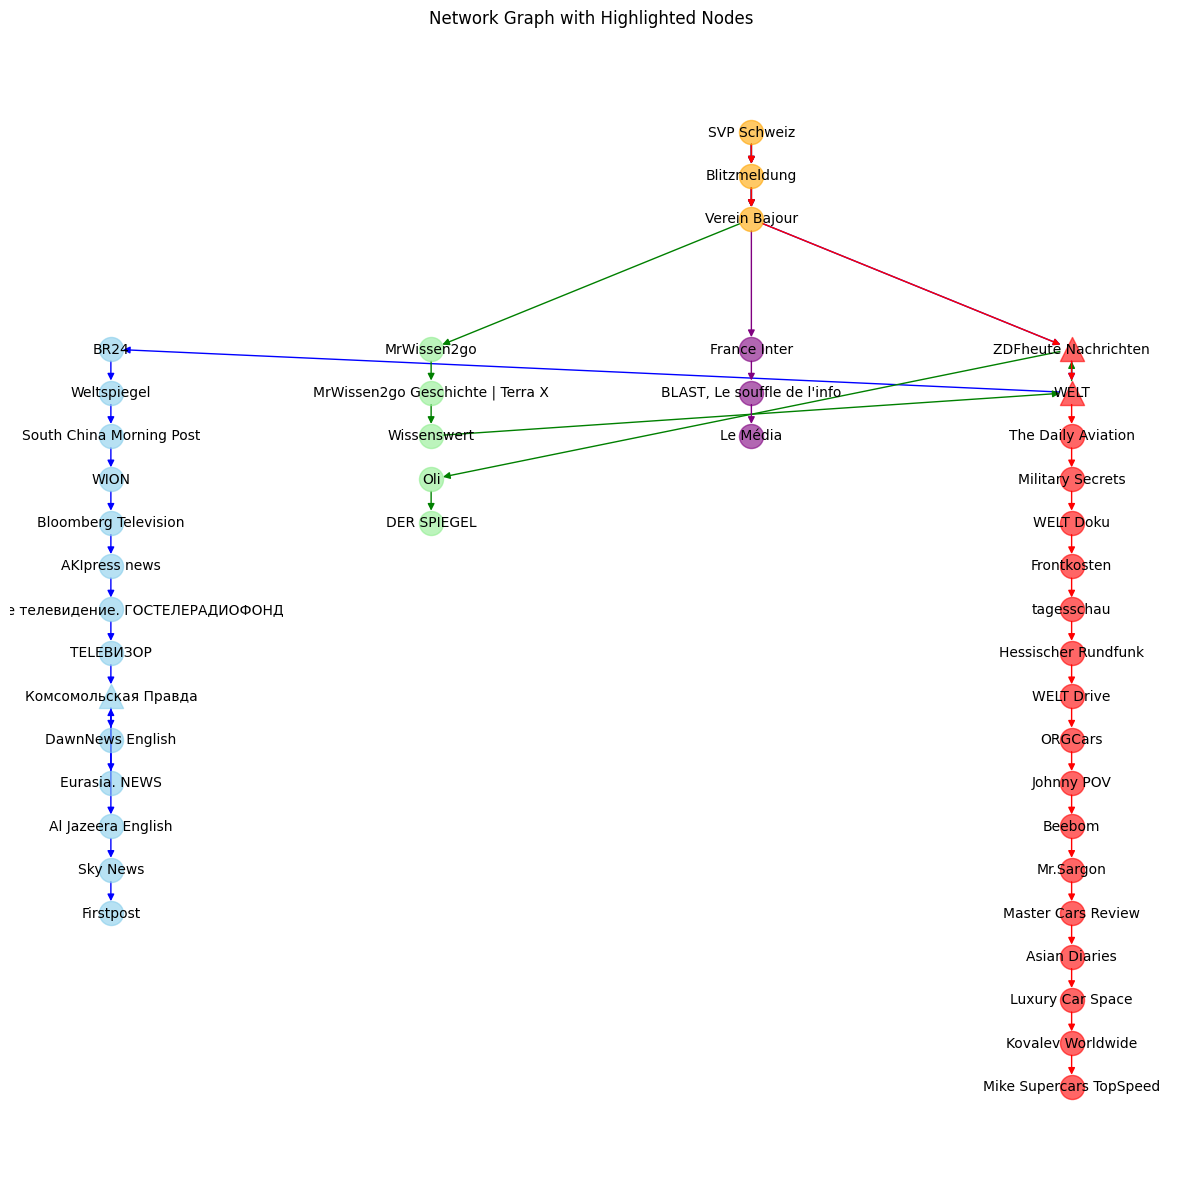

In [373]:

graphs = {}
layer_mapping = {key: i for i, key in enumerate(dfs.keys())}

# Create graphs for each DataFrame, avoiding self-loops and assigning initial layers
for key, df in dfs.items():
    G = nx.DiGraph()
    current_layer = layer_mapping[key]
    for i in range(len(df) - 1):
        src = df.iloc[i]['Channel']
        tgt = df.iloc[i + 1]['Channel']
        if src != tgt:
            G.add_node(src, Training=df.iloc[i]['Training'], layer=current_layer)
            G.add_node(tgt, Training=df.iloc[i + 1]['Training'], layer=current_layer)
            G.add_edge(src, tgt)
    graphs[key] = G

# Combine all individual graphs into a single graph
combined_graph = nx.compose_all(graphs.values())

# Calculate the median layer to position 'Training' nodes
total_layers = list(layer_mapping.values())
median_layer = ceil(np.median(total_layers))

# Update the layer for nodes where 'Training' is True to the median layer
for node, data in combined_graph.nodes(data=True):
    if data.get('Training'):
        data['layer'] = median_layer

# Apply a hierarchical layout using 'dot'
pos = graphviz_layout(combined_graph, prog='dot')

# Spread nodes in the same adjusted layer horizontally to emphasize parallel paths
layers = {}

for node, data in combined_graph.nodes(data=True):
    layer = data['layer']
    if layer not in layers:
        layers[layer] = []
    layers[layer].append(node)

for layer, nodes in layers.items():
    for i, node in enumerate(nodes):
        pos[node] = (layer * 100, pos[node][1] )  


minimum_distance=100
# Sorting nodes in each layer by their y-position and adjusting positions if too close
for layer, nodes in layers.items():
    sorted_nodes = sorted(nodes, key=lambda n: pos[n][1])
    for i in range(1, len(sorted_nodes)):
        current_pos = pos[sorted_nodes[i]][1]
        previous_pos = pos[sorted_nodes[i - 1]][1]
        if current_pos - previous_pos < minimum_distance:
            pos[sorted_nodes[i]] = (pos[sorted_nodes[i]][0], previous_pos + minimum_distance)

# First pass to find the lowest y-position of training nodes across all layers
min_y_for_training = float('inf')
for node, data in combined_graph.nodes(data=True):
    if data['Training'] and pos[node][1] < min_y_for_training:
        min_y_for_training = pos[node][1]

# Second pass to adjust y-positions for non-training nodes
adjustment = {}
for node, data in combined_graph.nodes(data=True):
    if not data['Training']:
        layer = data['layer']
        if layer not in adjustment:
            # Find the highest y-position of non-training nodes in the same layer
            max_y_in_layer = max(pos[n][1] for n in combined_graph.nodes if combined_graph.nodes[n]['layer'] == layer and not combined_graph.nodes[n]['Training'])
            adjustment[layer] = min_y_for_training-300 - max_y_in_layer
        # Apply adjustment
        pos[node] = (pos[node][0], pos[node][1] + adjustment[layer])


# Indegree calculation
indegree_map = dict(combined_graph.in_degree())

# Shapes for different indegrees
shapes = [ '','o','^', 's', 'p', '*', 'h', 'H', 'D', 'd', '|', '_']
# Mapping indegrees to shapes dynamically
unique_indegrees = sorted(set(indegree_map.values()))
indegree_to_shape = {deg: shapes[i % len(shapes)] for i, deg in enumerate(unique_indegrees) if deg > 1}

# Assign shapes based on indegree
node_shapes = {node: indegree_to_shape.get(indegree, 'o') for node, indegree in indegree_map.items()}


plt.figure(figsize=(15, 15))
colors = ['skyblue', 'lightgreen', 'purple', 'red', 'grey', 'pink', 'brown']
edge_colors = ['blue', 'green', 'purple', 'red', 'darkgrey', 'pink', 'brown']


# Draw all nodes first
for node in combined_graph.nodes():
    node_data = combined_graph.nodes[node]
    color = 'orange' if node_data['Training'] else colors[node_data['layer'] % len(colors)]
    shape = node_shapes[node]
    nx.draw_networkx_nodes(combined_graph, pos, nodelist=[node], node_color=color, node_shape=shape, node_size=300, alpha=0.6)

# Draw the graphs, separating calls by node shape
for i, (key, graph) in enumerate(graphs.items()):
    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors[i], style='solid', arrows=True)


# Draw edges
nx.draw_networkx_labels(combined_graph, pos, font_color='black', font_size=10)

plt.title('Network Graph with Highlighted Nodes')
plt.axis('off')
plt.show()


## Pizza

In [359]:
# Define the path and the file names
base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/pizza-runs/'
runs = ['run148.csv', 'run149.csv','run150.csv','run151.csv','run152.csv']

# Create a dictionary to hold the dataframes
dfs = {}

# Load each file into the dictionary
for run in runs:
    run_number = run.split('.')[0]  # This will extract the part of the filename without '.csv'
    dfs[run_number] = pd.read_csv(base_path + run)

# Optionally process each dataframe
for df_key in dfs:
    dfs[df_key] = dfs[df_key].drop_duplicates()

# To access and work with a specific dataframe, you can do it by its key:
dfs['run148'].head(10)

,Unnamed: 0,Title,Channel,url,video_list,Training
0,0,How to Make Perfect Pizza | Gennaro Contaldo,Jamie Oliver,https://www.youtube.com/watch?v=1-SJGQ2HLp8,Pizza,True
1,1,How to Make NEAPOLITAN PIZZA DOUGH like a Worl...,Vincenzo's Plate,https://www.youtube.com/watch?v=8Q_9h6VKm9c,Pizza,True
2,2,The Best Homemade Pizza You'll Ever Eat,Tasty,https://www.youtube.com/watch?v=sv3TXMSv6Lw,Pizza,True
3,3,Pizza Dough Recipe,Preppy Kitchen,https://www.youtube.com/watch?v=Eim2GpHNQDg,Pizza,True
4,4,The Best Pizza In Naples | Best Of The Best,Insider Food,https://www.youtube.com/watch?v=7toSikYGFNM,Pizza,True
5,5,Perfect Pizza at Home,Nino's Home,https://www.youtube.com/watch?v=PCAwJs51D0k,Pizza,True
6,6,HOW TO MAKE NEXT LEVEL PIZZA DOUGH | DOUBLE FE...,Vito Iacopelli,https://www.youtube.com/watch?v=u7Hd6ZzKgBM,Pizza,True
7,7,Best Homemade Pizza Dough Recipe | How To Make...,Natashas Kitchen,https://www.youtube.com/watch?v=WM1XcYXix0Y,Pizza,True
8,8,Making Dominos Pizza At Home (2 Ways) | But Be...,Joshua Weissman,https://www.youtube.com/watch?v=GMYwTEek9mg,Pizza,True
9,9,Learn How to Make the Best Homemade Pizza with...,Citalia,https://www.youtube.com/watch?v=n-VRntrbypI,Pizza,True


/home/shutingmi/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shutingmi/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23068 (\N{CJK UNIFIED IDEOGRAPH-5A1C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shutingmi/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22969 (\N{CJK UNIFIED IDEOGRAPH-59B9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shutingmi/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27224 (\N{CJK UNIFIED IDEOGRAPH-6A58}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shutingmi/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23569 (\N{CJK UNIFIED IDEOGRAPH-5C11}) missing from c

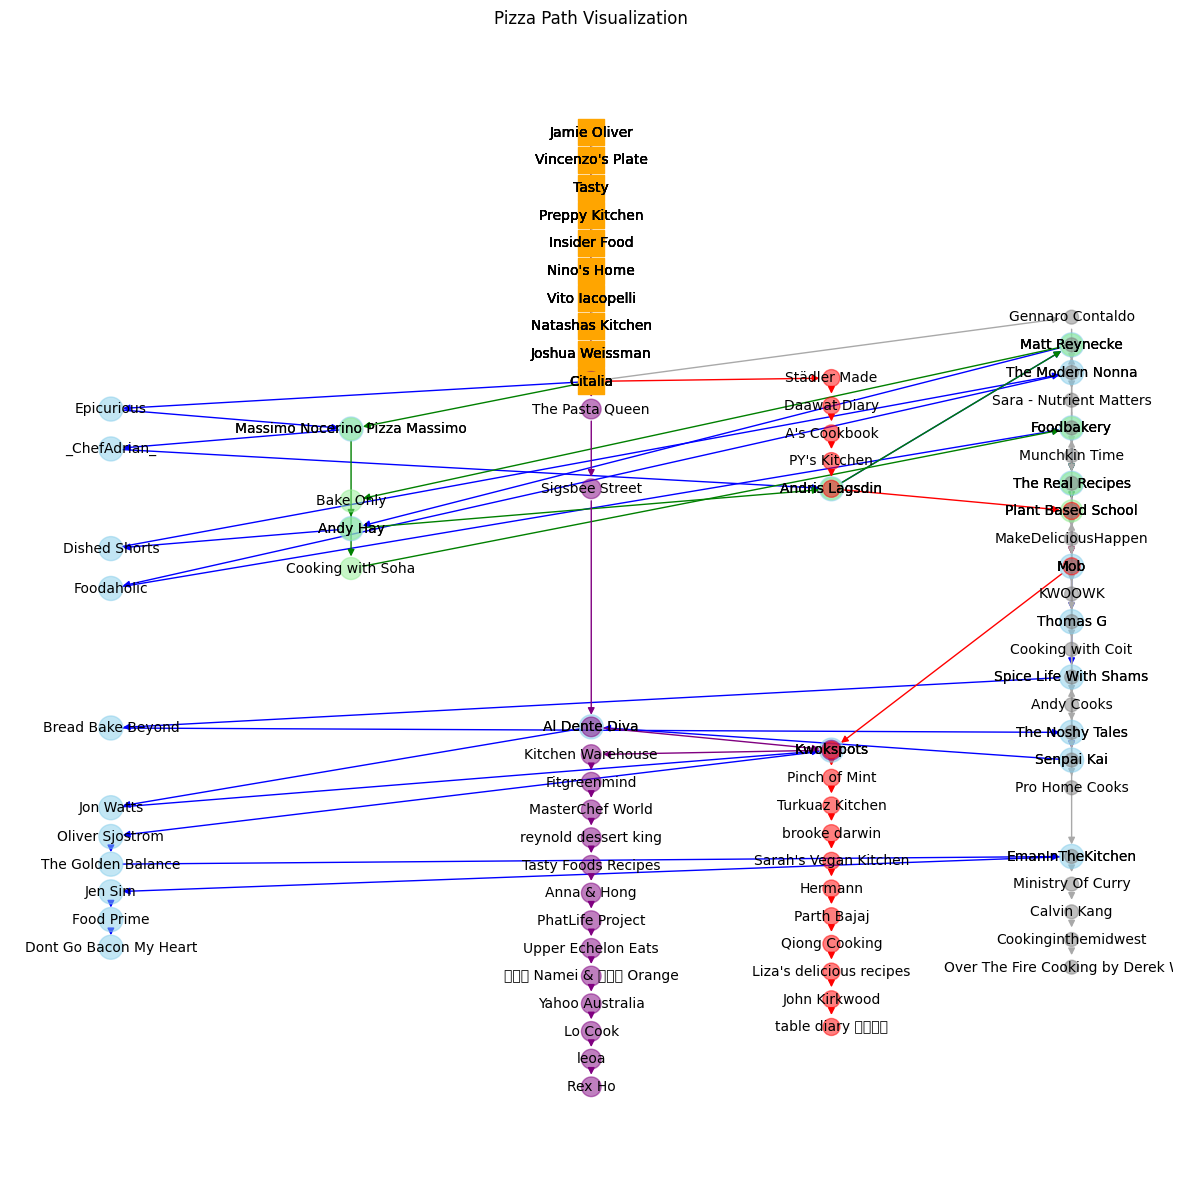

In [326]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from math import ceil
import numpy as np

# Assume dfs and graphs setup is already done as per previous snippets
graphs = {}
layer_mapping = {key: i for i, key in enumerate(dfs.keys())}

# Create graphs for each DataFrame
for key, df in dfs.items():
    G = nx.DiGraph()
    current_layer = layer_mapping[key]
    for i in range(len(df) - 1):
        src = df.iloc[i]['Channel']
        tgt = df.iloc[i + 1]['Channel']
        if src != tgt:
            G.add_node(src, Training=df.iloc[i]['Training'], layer=current_layer)
            G.add_node(tgt, Training=df.iloc[i + 1]['Training'], layer=current_layer)
            G.add_edge(src, tgt)
    graphs[key] = G

combined_graph = nx.compose_all(graphs.values())
total_layers = list(layer_mapping.values())
median_layer = ceil(np.median(total_layers))

for node, data in combined_graph.nodes(data=True):
    if data['Training']:
        data['layer'] = median_layer

pos = graphviz_layout(combined_graph, prog='dot')

# Spread nodes in the same adjusted layer horizontally to emphasize parallel paths
layers = {}
for node, data in combined_graph.nodes(data=True):
    layer = data['layer']
    if layer not in layers:
        layers[layer] = []
    layers[layer].append(node)

for layer, nodes in layers.items():
    for i, node in enumerate(nodes):
        pos[node] = (layer * 100, pos[node][1] )  

minimum_distance=100
# Sorting nodes in each layer by their y-position and adjusting positions if too close
for layer, nodes in layers.items():
    sorted_nodes = sorted(nodes, key=lambda n: pos[n][1])
    for i in range(1, len(sorted_nodes)):
        current_pos = pos[sorted_nodes[i]][1]
        previous_pos = pos[sorted_nodes[i - 1]][1]
        if current_pos - previous_pos < minimum_distance:
            pos[sorted_nodes[i]] = (pos[sorted_nodes[i]][0], previous_pos + minimum_distance)


plt.figure(figsize=(15, 15))
colors = ['skyblue', 'lightgreen', 'purple', 'red', 'grey', 'pink', 'brown']
edge_colors = ['blue', 'green', 'purple', 'red', 'darkgrey', 'pink', 'brown']

# Draw the graphs, separating calls by node shape
for i, (key, graph) in enumerate(graphs.items()):
    training_nodes = [node for node in graph if graph.nodes[node]['Training']]
    non_training_nodes = [node for node in graph if not graph.nodes[node]['Training']]
    node_colors_training = ['orange' for _ in training_nodes]
    node_colors_non_training = [colors[i % len(colors)] for _ in non_training_nodes]

    # Draw training nodes
    nx.draw_networkx_nodes(graph, pos, nodelist=training_nodes, node_color=node_colors_training, node_shape='s', node_size=350 - i*50, alpha=1)
    # Draw non-training nodes
    nx.draw_networkx_nodes(graph, pos, nodelist=non_training_nodes, node_color=node_colors_non_training, node_shape='o', node_size=300 - i*50, alpha=0.5)

    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors[i], style='solid', arrows=True)
    nx.draw_networkx_labels(graph, pos, font_color='black', font_size=10)

plt.title('Pizza Path Visualization')
plt.axis('off')
plt.show()

# Find the nodes with the highest indegree
indegrees = combined_graph.in_degree()
max_indegree = max(dict(indegrees).values())
max_indegree
high_indegree_nodes = [node for node, deg in dict(indegrees).items() if deg == max_indegree]

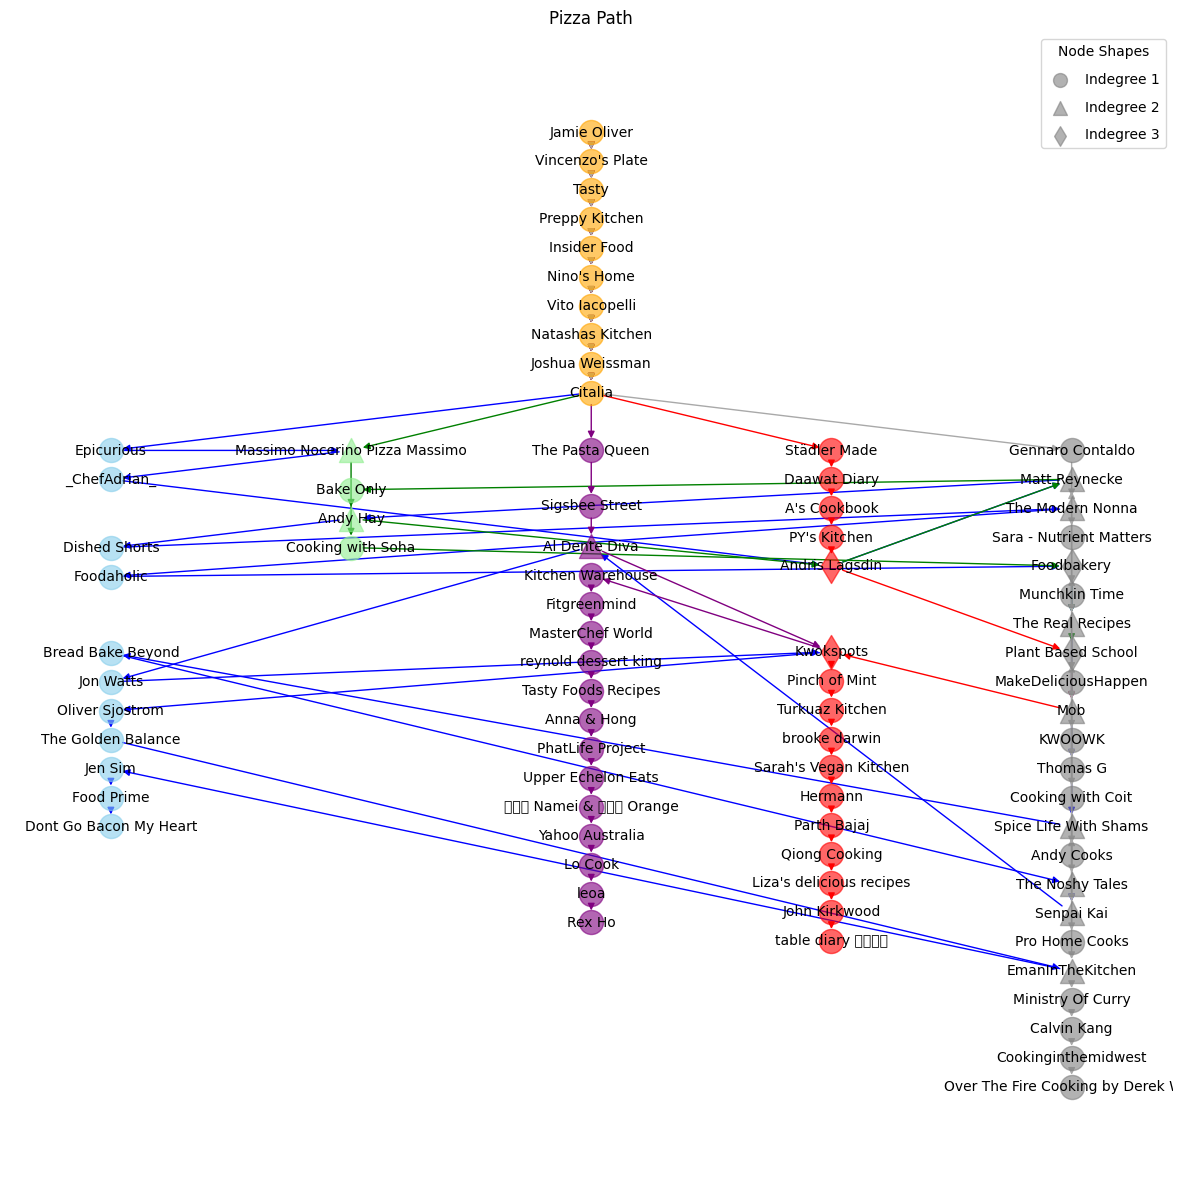

In [371]:

graphs = {}
layer_mapping = {key: i for i, key in enumerate(dfs.keys())}

# Create graphs for each DataFrame, avoiding self-loops and assigning initial layers
for key, df in dfs.items():
    G = nx.DiGraph()
    current_layer = layer_mapping[key]
    for i in range(len(df) - 1):
        src = df.iloc[i]['Channel']
        tgt = df.iloc[i + 1]['Channel']
        if src != tgt:
            G.add_node(src, Training=df.iloc[i]['Training'], layer=current_layer)
            G.add_node(tgt, Training=df.iloc[i + 1]['Training'], layer=current_layer)
            G.add_edge(src, tgt)
    graphs[key] = G

# Combine all individual graphs into a single graph
combined_graph = nx.compose_all(graphs.values())

# Calculate the median layer to position 'Training' nodes
total_layers = list(layer_mapping.values())
median_layer = ceil(np.median(total_layers))

# Update the layer for nodes where 'Training' is True to the median layer
for node, data in combined_graph.nodes(data=True):
    if data.get('Training'):
        data['layer'] = median_layer

# Apply a hierarchical layout using 'dot'
pos = graphviz_layout(combined_graph, prog='dot')

# Spread nodes in the same adjusted layer horizontally to emphasize parallel paths
layers = {}

for node, data in combined_graph.nodes(data=True):
    layer = data['layer']
    if layer not in layers:
        layers[layer] = []
    layers[layer].append(node)

for layer, nodes in layers.items():
    for i, node in enumerate(nodes):
        pos[node] = (layer * 100, pos[node][1] )  


minimum_distance=150
# Sorting nodes in each layer by their y-position and adjusting positions if too close
for layer, nodes in layers.items():
    sorted_nodes = sorted(nodes, key=lambda n: pos[n][1])
    for i in range(1, len(sorted_nodes)):
        current_pos = pos[sorted_nodes[i]][1]
        previous_pos = pos[sorted_nodes[i - 1]][1]
        if current_pos - previous_pos < minimum_distance:
            pos[sorted_nodes[i]] = (pos[sorted_nodes[i]][0], previous_pos + minimum_distance)

# First pass to find the lowest y-position of training nodes across all layers
min_y_for_training = float('inf')
for node, data in combined_graph.nodes(data=True):
    if data['Training'] and pos[node][1] < min_y_for_training:
        min_y_for_training = pos[node][1]

# Second pass to adjust y-positions for non-training nodes
adjustment = {}
for node, data in combined_graph.nodes(data=True):
    if not data['Training']:
        layer = data['layer']
        if layer not in adjustment:
            # Find the highest y-position of non-training nodes in the same layer
            max_y_in_layer = max(pos[n][1] for n in combined_graph.nodes if combined_graph.nodes[n]['layer'] == layer and not combined_graph.nodes[n]['Training'])
            adjustment[layer] = min_y_for_training-300 - max_y_in_layer
        # Apply adjustment
        pos[node] = (pos[node][0], pos[node][1] + adjustment[layer])

# Determine indegrees and assign shapes
indegrees = combined_graph.in_degree()
shapes = [' ', 'o', '^', 'd', 'p','*']  # Limited set of shapes for example
shape_legend = {}

for node, deg in indegrees:
    if deg > 0:
        shape = shapes[deg % len(shapes)] if deg < len(shapes) else shapes[-1]
        shape_legend[deg] = shape
    else:
        shape = 'o'
    combined_graph.nodes[node]['shape'] = shape


plt.figure(figsize=(15, 15))
colors = ['skyblue', 'lightgreen', 'purple', 'red', 'grey', 'pink', 'brown']
edge_colors = ['blue', 'green', 'purple', 'red', 'darkgrey', 'pink', 'brown']


# Draw all nodes first
for node in combined_graph.nodes():
    node_data = combined_graph.nodes[node]
    color = 'orange' if node_data['Training'] else colors[node_data['layer'] % len(colors)]
    shape = node_data['shape']
    nx.draw_networkx_nodes(combined_graph, pos, nodelist=[node], node_color=color, node_shape=shape, node_size=300, alpha=0.6)

# Draw the graphs, separating calls by node shape
for i, (key, graph) in enumerate(graphs.items()):
    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors[i], style='solid', arrows=True)


# Draw edges
nx.draw_networkx_labels(combined_graph, pos, font_color='black', font_size=10)

# Add legend for shapes
for deg, shape in shape_legend.items():
    plt.scatter([], [], c='gray', alpha=0.6, s=100, marker=shape, label=f'Indegree {deg}')

plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Node Shapes')

plt.title('Pizza Path')
plt.axis('off')
plt.show()


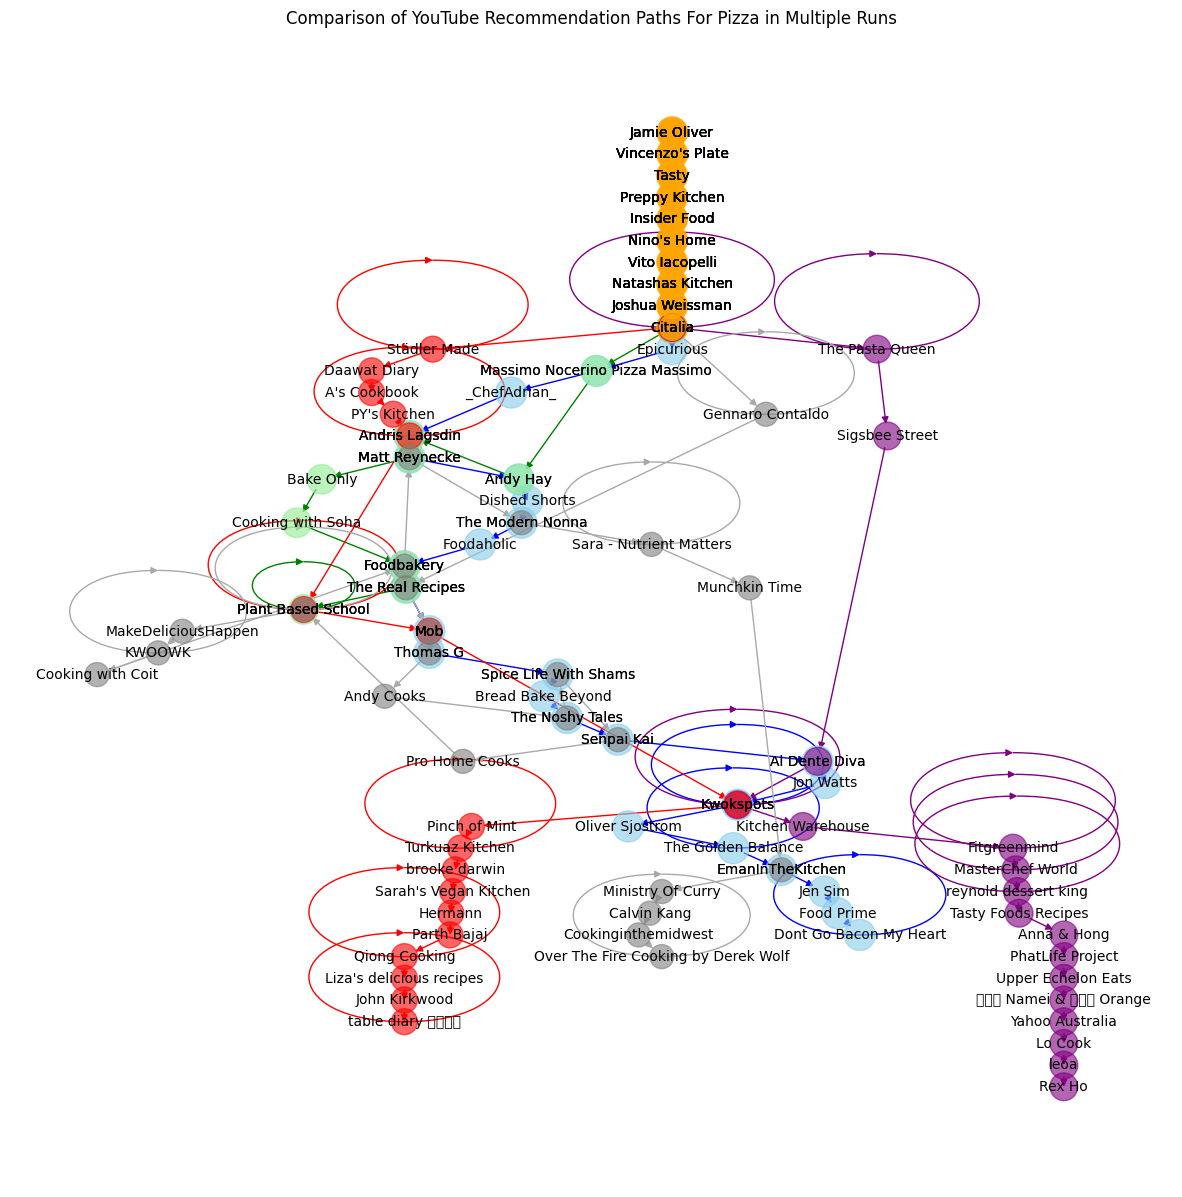

In [247]:

# Assuming your data is already loaded into dfs, a dictionary of dataframes
graphs = {}  # Dictionary to store the graphs

# Create directed graphs for each DataFrame, storing node 'Training' attribute
for key, df in dfs.items():
    G = nx.DiGraph()
    for i in range(len(df) - 1):
        G.add_edge(df.iloc[i]['Channel'], df.iloc[i + 1]['Channel'])
        # Assign attributes to nodes when adding edges
        G.nodes[df.iloc[i]['Channel']]['Training'] = df.iloc[i]['Training']
        G.nodes[df.iloc[i + 1]['Channel']]['Training'] = df.iloc[i + 1]['Training']
    graphs[key] = G  # Store each graph in the dictionary with the same key as the dataframe

# Combine all graphs for the layout calculation
combined_graph = nx.compose_all(graphs.values())

# Generate a layout based on all nodes in the combined graph using dot, with adjusted settings
pos = graphviz_layout(combined_graph, prog='dot')

# Setup plot parameters
plt.figure(figsize=(15, 15))
colors = ['skyblue', 'lightgreen', 'purple','red','grey','pink','brown']  # Different colors for different graphs
edge_colors = ['blue', 'green', 'purple','red','darkgrey','pink','brown']  # Different edge colors

# Draw the graphs
for i, (key, graph) in enumerate(graphs.items()):
    node_colors = [ 'orange' if graph.nodes[node]['Training'] else colors[i] for node in graph]
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=500 - i*50, alpha=0.6)
    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors[i], style='solid', arrows=True)
    nx.draw_networkx_labels(graph, pos, font_color='black', font_size=10)

plt.title('Comparison of YouTube Recommendation Paths For Pizza in Multiple Runs')
plt.axis('off')
plt.show()


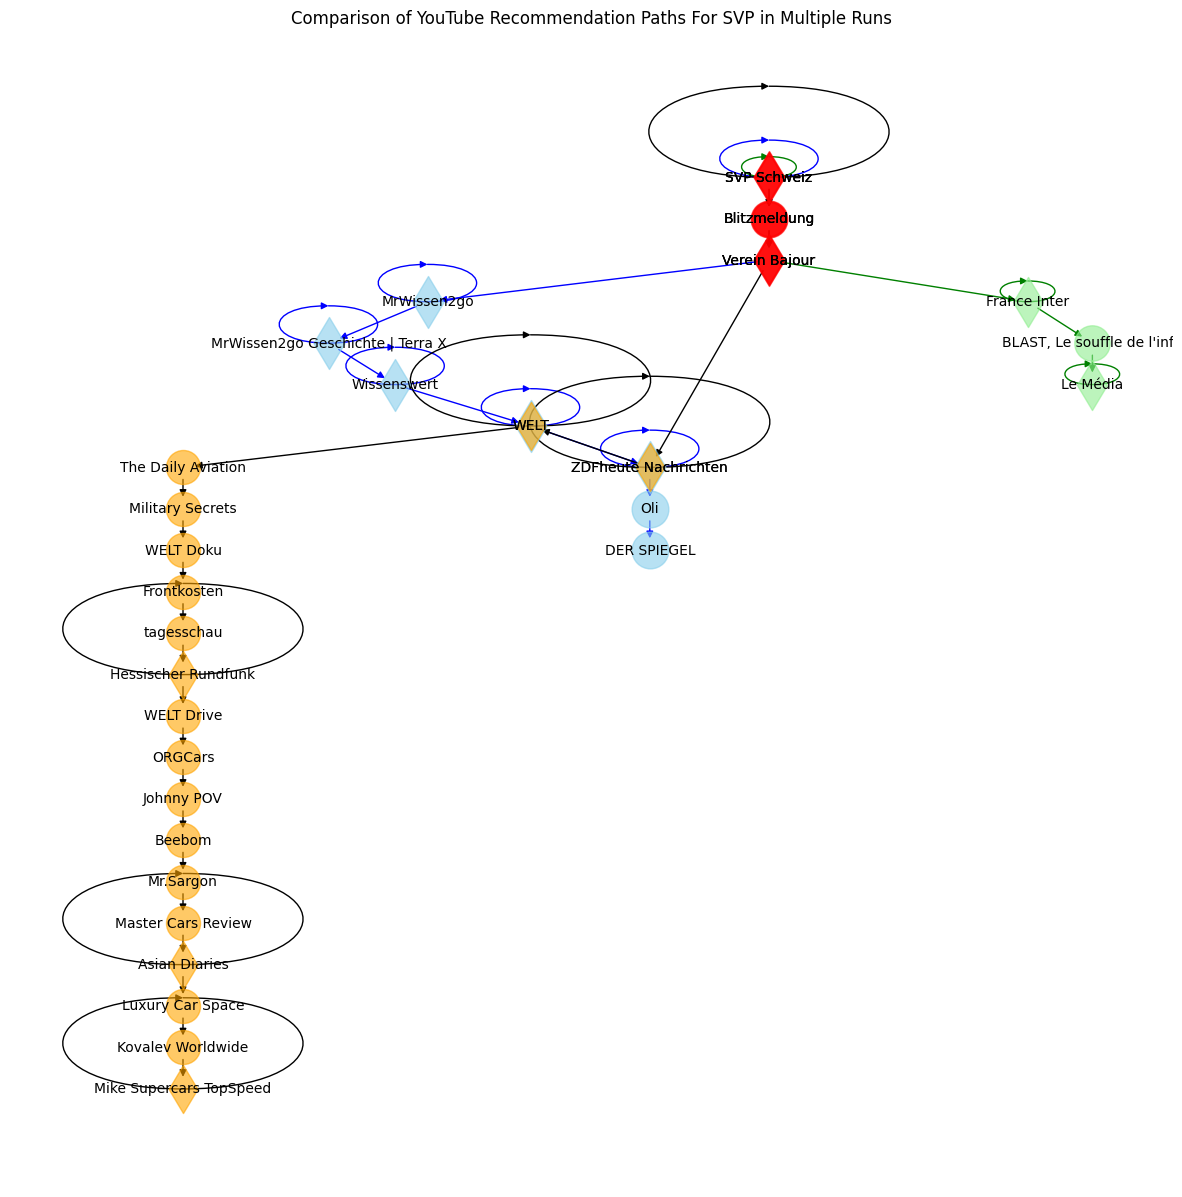

In [70]:
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

# Assuming your data is already loaded into dfs, a dictionary of dataframes
graphs = {}  # Dictionary to store the graphs

# Create directed graphs for each DataFrame, storing node 'Training' attribute
for key, df in dfs.items():
    G = nx.DiGraph()
    for i in range(len(df) - 1):
        G.add_edge(df.iloc[i]['Channel'], df.iloc[i + 1]['Channel'])
        # Assign attributes to nodes when adding edges
        G.nodes[df.iloc[i]['Channel']]['Training'] = df.iloc[i]['Training']
        G.nodes[df.iloc[i + 1]['Channel']]['Training'] = df.iloc[i + 1]['Training']
    graphs[key] = G  # Store each graph in the dictionary with the same key as the dataframe

# Combine all graphs for the layout calculation
combined_graph = nx.compose_all(graphs.values())

# Generate a layout based on all nodes in the combined graph using dot, with adjusted settings
pos = graphviz_layout(combined_graph, prog='dot')

# Setup plot parameters
plt.figure(figsize=(15, 15))
colors = ['skyblue', 'lightgreen', 'orange', 'red', 'purple']  # Different colors for different graphs
edge_colors = ['blue', 'green', 'black', 'red', 'purple']  # Different edge colors

# Identify nodes at intersections
intersection_nodes = [node for node in combined_graph.nodes() if combined_graph.in_degree(node) > 1 or combined_graph.out_degree(node) > 1]

# Draw the graphs
for i, (key, graph) in enumerate(graphs.items()):
    # Draw each node based on the 'Training' attribute
    for node in graph.nodes:
        node_color = 'red' if graph.nodes[node]['Training'] else colors[i]
        if node in intersection_nodes:
            node_shape = 'd'  # diamond shape for intersection nodes
        else:
            node_shape = 'o'  # circle for others

        nx.draw_networkx_nodes(graph, pos, nodelist=[node], node_color=node_color, node_size=700 - i*50, node_shape=node_shape, alpha=0.6)

    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors[i], style='solid', arrows=True)
    nx.draw_networkx_labels(graph, pos, font_color='black', font_size=10)

plt.title('Comparison of YouTube Recommendation Paths For SVP in Multiple Runs')
plt.axis('off')
plt.show()


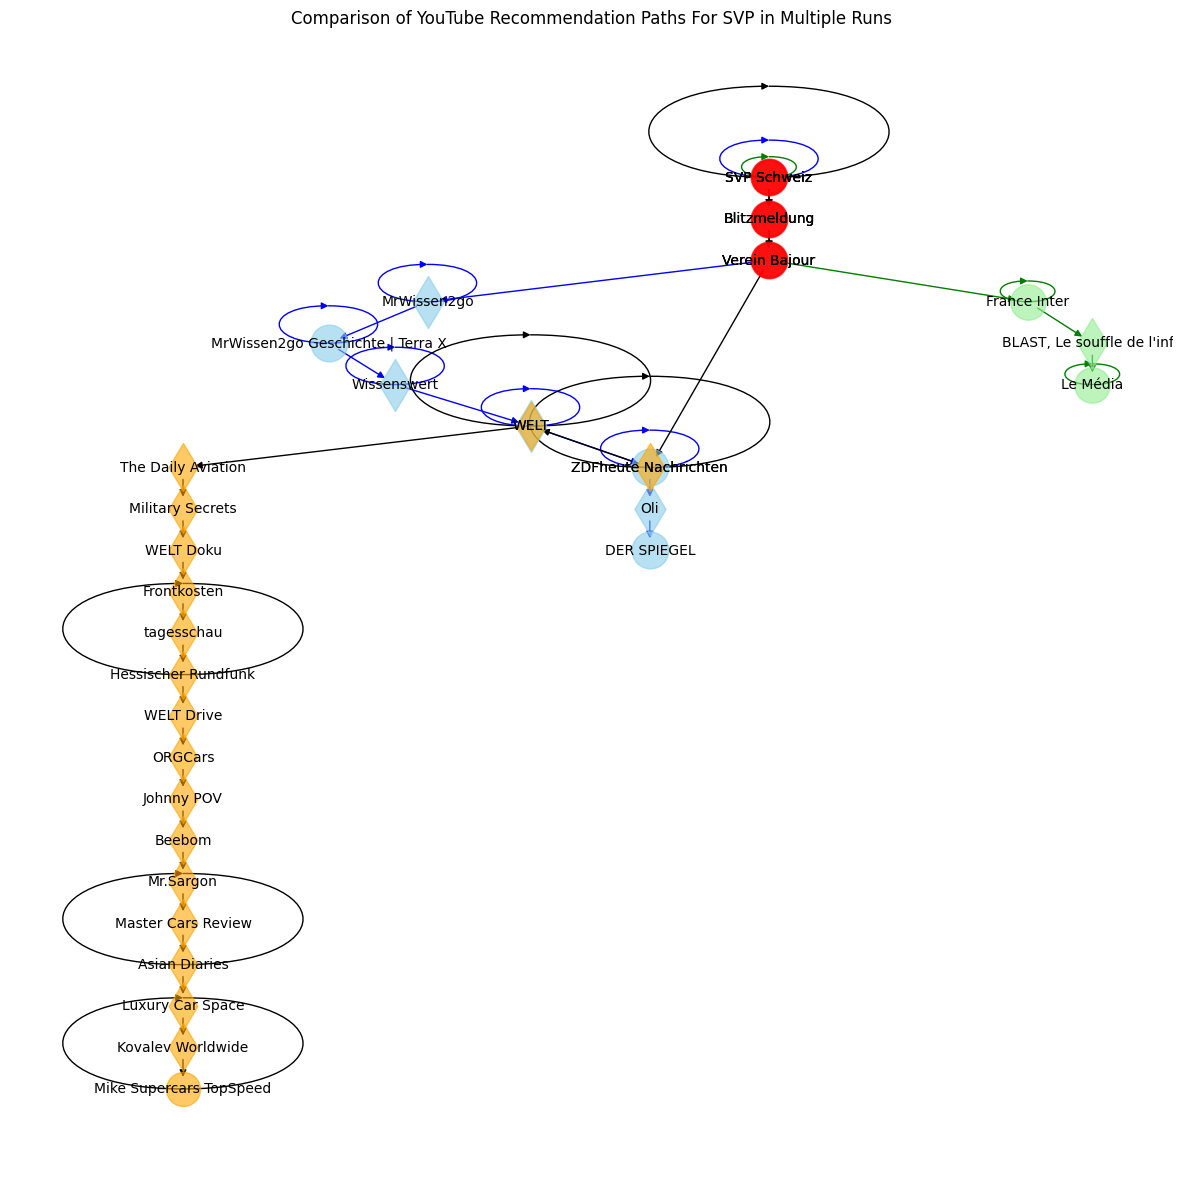

In [72]:
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

# Assuming your data is already loaded into dfs, a dictionary of dataframes
graphs = {}  # Dictionary to store the graphs

# Create directed graphs for each DataFrame, storing node 'Training' attribute
for key, df in dfs.items():
    G = nx.DiGraph()
    for i in range(len(df) - 1):
        G.add_edge(df.iloc[i]['Channel'], df.iloc[i + 1]['Channel'], color=colors[i % len(colors)])
        # Assign attributes to nodes when adding edges
        G.nodes[df.iloc[i]['Channel']]['Training'] = df.iloc[i]['Training']
        G.nodes[df.iloc[i + 1]['Channel']]['Training'] = df.iloc[i + 1]['Training']
    graphs[key] = G  # Store each graph in the dictionary with the same key as the dataframe

# Combine all graphs for the layout calculation
combined_graph = nx.compose_all(graphs.values())

# Generate a layout based on all nodes in the combined graph using dot, with adjusted settings
pos = graphviz_layout(combined_graph, prog='dot')

# Setup plot parameters
plt.figure(figsize=(15, 15))
colors = ['skyblue', 'lightgreen', 'orange', 'red', 'purple']  # Different colors for different graphs
edge_colors = ['blue', 'green', 'black', 'red', 'purple']  # Different edge colors

# Draw the graphs
for i, (key, graph) in enumerate(graphs.items()):
    for node in graph.nodes:
        connected_edge_colors = set()
        for edge in graph.in_edges(node, data=True):
            if edge[0] != node:  # Avoid self-loops
                connected_edge_colors.add(edge[2]['color'])
        for edge in graph.out_edges(node, data=True):
            if edge[1] != node:  # Avoid self-loops
                connected_edge_colors.add(edge[2]['color'])

        if len(connected_edge_colors) >= 2 and not graph.nodes[node]['Training']:
            node_shape = 'd'  # Diamond shape for nodes with two or more different colored edges
        else:
            node_shape = 'o'  # Circle otherwise

        node_color = 'red' if graph.nodes[node]['Training'] else colors[i % len(colors)]
        nx.draw_networkx_nodes(graph, pos, nodelist=[node], node_color=node_color, node_size=700 - i*50, node_shape=node_shape, alpha=0.6)

    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors[i], style='solid', arrows=True)
    nx.draw_networkx_labels(graph, pos, font_color='black', font_size=10)

plt.title('Comparison of YouTube Recommendation Paths For SVP in Multiple Runs')
plt.axis('off')
plt.show()


## AFD

In [43]:
# Define the path and the file names
base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/'
runs = ['run52.csv', 'run53.csv', 'run54.csv']

# Create a dictionary to hold the dataframes
dfs = {}

# Load each file into the dictionary
for run in runs:
    run_number = run.split('.')[0]  # This will extract the part of the filename without '.csv'
    dfs[run_number] = pd.read_csv(base_path + run)

# Optionally process each dataframe
for df_key in dfs:
    dfs[df_key] = dfs[df_key].drop_duplicates()

# To access and work with a specific dataframe, you can do it by its key:
dfs['run52'].head(10)

,Unnamed: 0,Title,Channel,url,video_list,Training
0,0,Ampel-Propaganda funktioniert nicht,Die Welt Klar Sehen!,https://www.youtube.com/watch?v=ngi53tvX9qI,AFD1,True
1,1,erschreckend: unzuverlässige Pandemie-Daten,Die Welt Klar Sehen!,https://www.youtube.com/watch?v=pdCvbp4baQY,AFD1,True
2,2,Alice Weidel zur Generaldebatte zum Bundeshaus...,phoenix,https://www.youtube.com/watch?v=hhUCIuC5PBc,AFD1,True
3,3,💥GRÜNE ERNÄHRUNGSKONTROLLE💥,Blitzmeldung,https://www.youtube.com/watch?v=1NJ3uviaZkc,AFD1,True
4,4,💥AfD POLITIKER SCHWER VERLETZT💥,Blitzmeldung,https://www.youtube.com/watch?v=d7FPTfAKgSk,AFD1,True
5,5,💥GRÜNER Bürgermeister geschlagen: KEINER beric...,Oli,https://www.youtube.com/watch?v=3G3Cg7RfFlY,AFD1,True
6,6,Sh*tstorm…Ganz Twitter Kocht Vor Wut!,Durchblick,https://www.youtube.com/watch?v=StdTMORlQBc,AFD1,True
7,7,Eilmeldung Eurowahl: AfD Stimmen explodieren u...,Durchblick,https://www.youtube.com/watch?v=tdv3PLDFNoQ,AFD1,True
8,8,Köstlich😂…Cannabis Verbot Offiziell!,Durchblick,https://www.youtube.com/watch?v=0od7fM2a4m4,AFD1,True
9,9,Endlich!!! Schweizer Journalist erteilt freche...,kritisch analysiert,https://www.youtube.com/watch?v=yTEy5Z03ups,AFD1,True


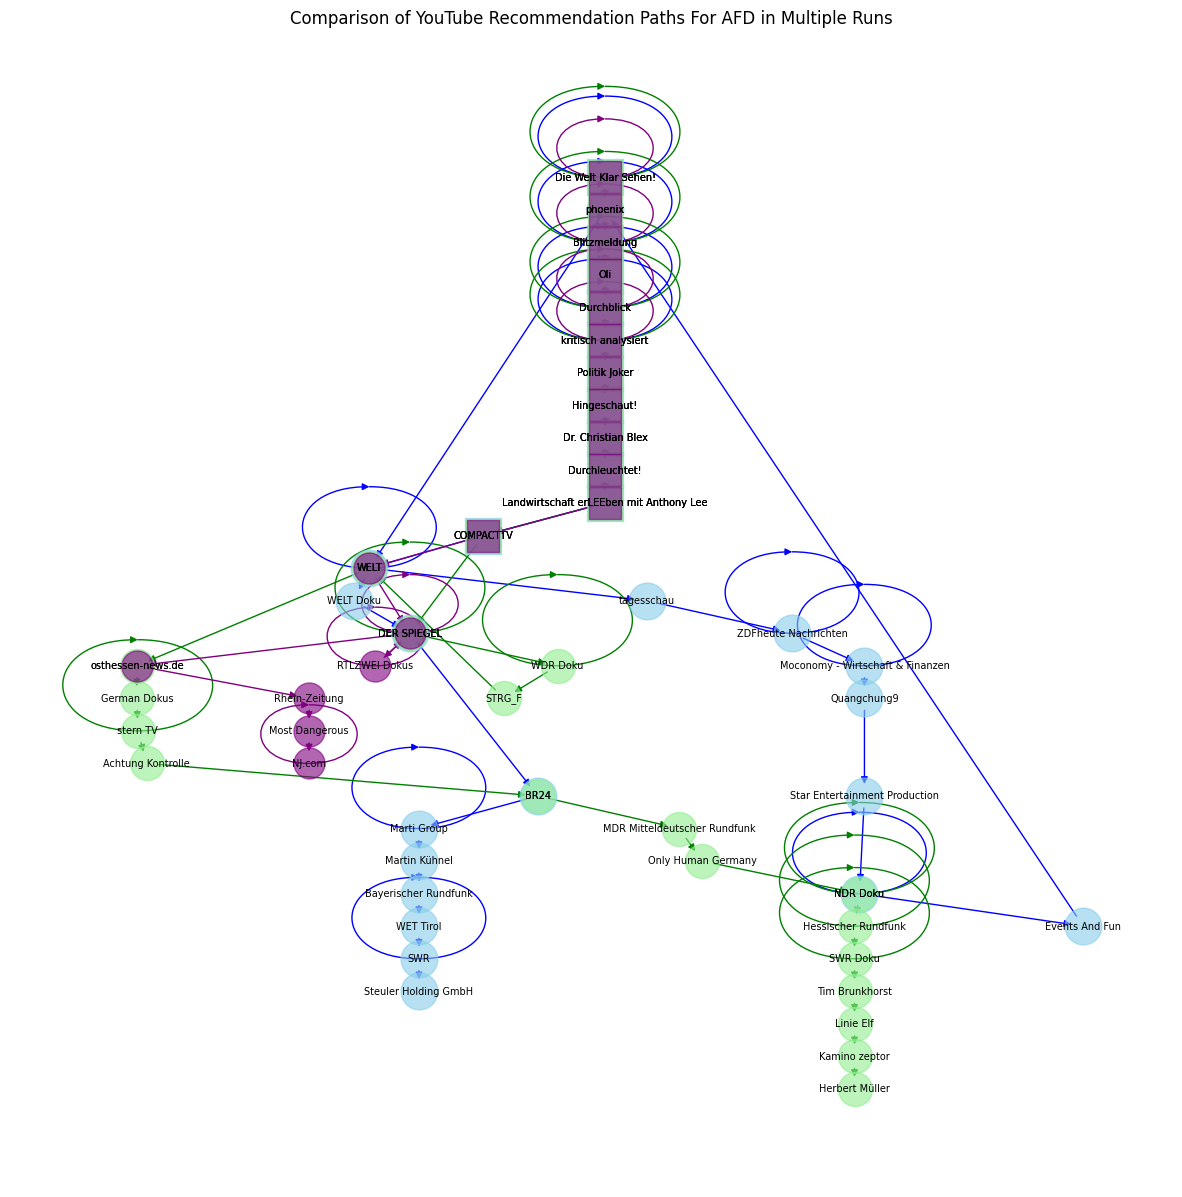

In [44]:
# Assuming the dataframes are stored in a dictionary `dfs` as previously discussed
graphs = {}  # Dictionary to store the graphs

# Create directed graphs for each DataFrame, storing node 'Training' attribute
for key, df in dfs.items():
    G = nx.DiGraph()
    for i in range(len(df) - 1):
        G.add_edge(df.iloc[i]['Channel'], df.iloc[i + 1]['Channel'])
        # Assign attributes to nodes when adding edges
        G.nodes[df.iloc[i]['Channel']]['Training'] = df.iloc[i]['Training']
        G.nodes[df.iloc[i + 1]['Channel']]['Training'] = df.iloc[i + 1]['Training']
    graphs[key] = G  # Store each graph in the dictionary with the same key as the dataframe

# Combine all graphs for the layout calculation
combined_graph = nx.compose_all(graphs.values())

# Generate a layout based on all nodes in the combined graph
#pos = nx.spring_layout(combined_graph, seed= 194)
#pos = nx.planar_layout(combined_graph)
pos = graphviz_layout(combined_graph, prog='dot')

# Setup plot parameters
plt.figure(figsize=(15, 15))
colors = ['skyblue', 'lightgreen', 'purple']  # Add more colors if you have more graphs
edge_colors = ['blue', 'green', 'purple']

# Draw the graphs
for i, (key, graph) in enumerate(graphs.items()):
    # Draw each node based on the 'Training' attribute
    for node in graph.nodes:
        shape = 's' if graph.nodes[node]['Training'] else 'o'  # Square if Training is True, otherwise circle
        nx.draw_networkx_nodes(graph, pos, nodelist=[node], node_shape=shape, node_size=700 - i*100, node_color=colors[i], alpha=0.6)
    nx.draw_networkx_edges(graph, pos, edge_color=edge_colors[i], style='solid')
    nx.draw_networkx_labels(graph, pos, font_color='black', font_size=7)

plt.title('Comparison of YouTube Recommendation Paths For AFD in Multiple Runs')
plt.axis('off')
plt.show()

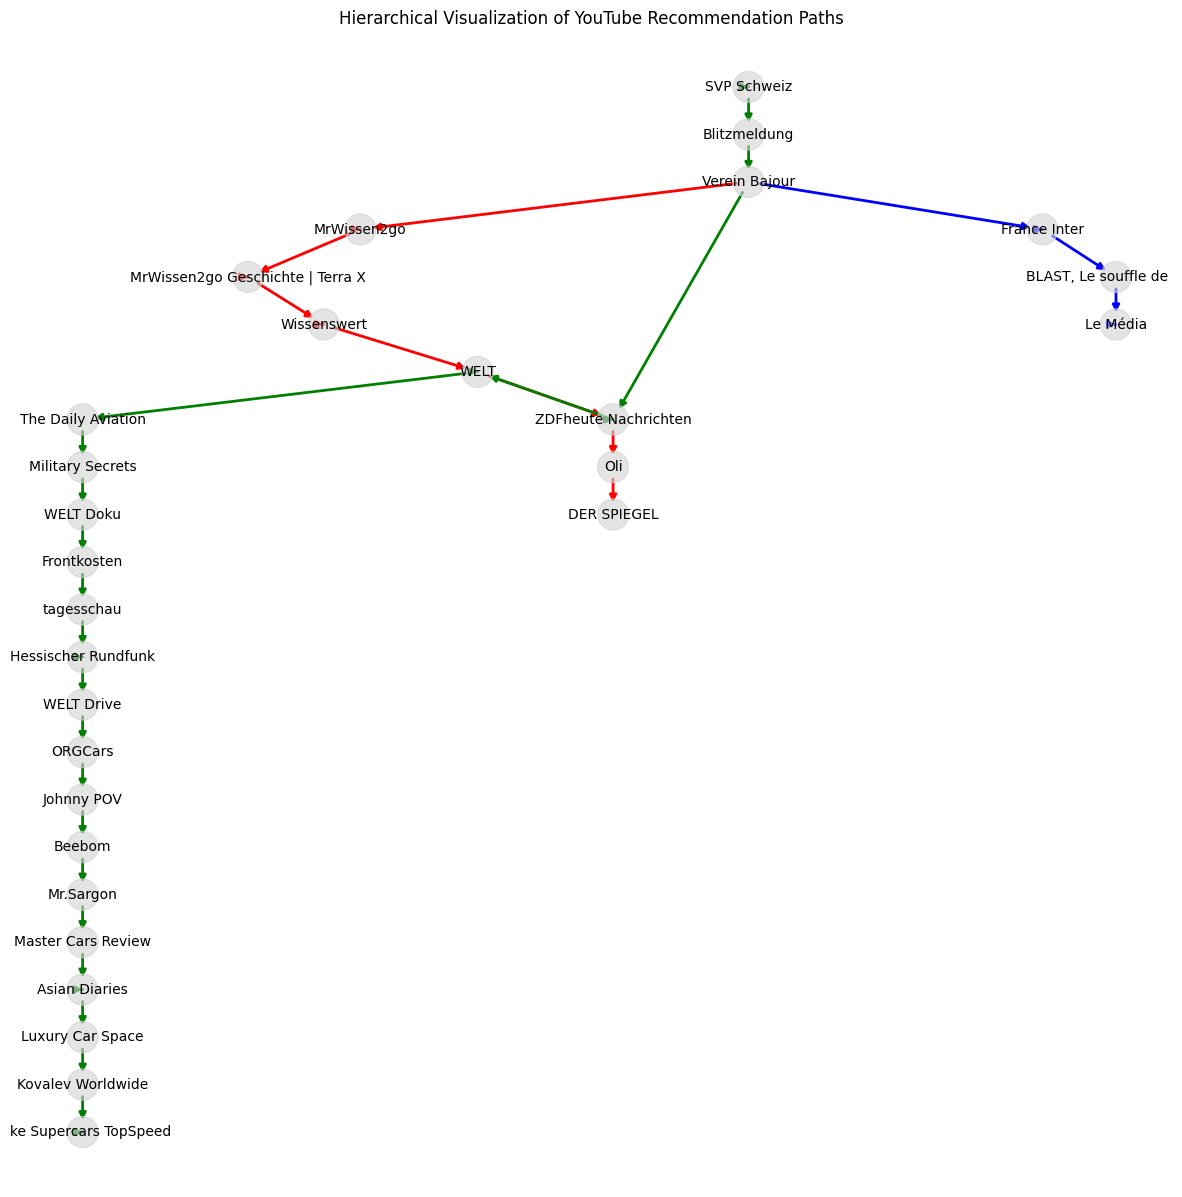

In [45]:
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

# Define the path and the file names
base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/'
runs = ['run55.csv', 'run56.csv', 'run57.csv']

# Create a dictionary to hold the dataframes
dfs = {}

# Load each file into the dictionary
for run in runs:
    run_number = run.split('.')[0]  # Extract the part of the filename without '.csv'
    dfs[run_number] = pd.read_csv(base_path + run)

# Unified graph to hold all data
G = nx.DiGraph()

# Populate the graph with nodes and edges
run_colors = {'run55': 'red', 'run56': 'blue', 'run57': 'green'}  # Different colors for different runs
for key, df in dfs.items():
    prev_node = None
    for idx, row in df.iterrows():
        node = row['Channel']
        training = row['Training'] == 'True'  # Assuming this is already boolean or 'True'/'False' string
        if not G.has_node(node):
            G.add_node(node, Training=training)

        if prev_node is not None:
            G.add_edge(prev_node, node, color=run_colors[key])  # Assign a color based on the run

        prev_node = node

# Apply Graphviz layout
pos = graphviz_layout(G, prog='dot')

# Setup plot parameters
plt.figure(figsize=(15, 15))

# Draw nodes and edges with colors
nx.draw_networkx_nodes(G, pos, node_size=500, alpha=0.6, node_color=[('skyblue' if G.nodes[node]['Training'] else 'lightgrey') for node in G])
for edge in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist=[(edge[0], edge[1])], width=2, edge_color=edge[2]['color'])

nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('Hierarchical Visualization of YouTube Recommendation Paths')
plt.axis('off')
plt.show()


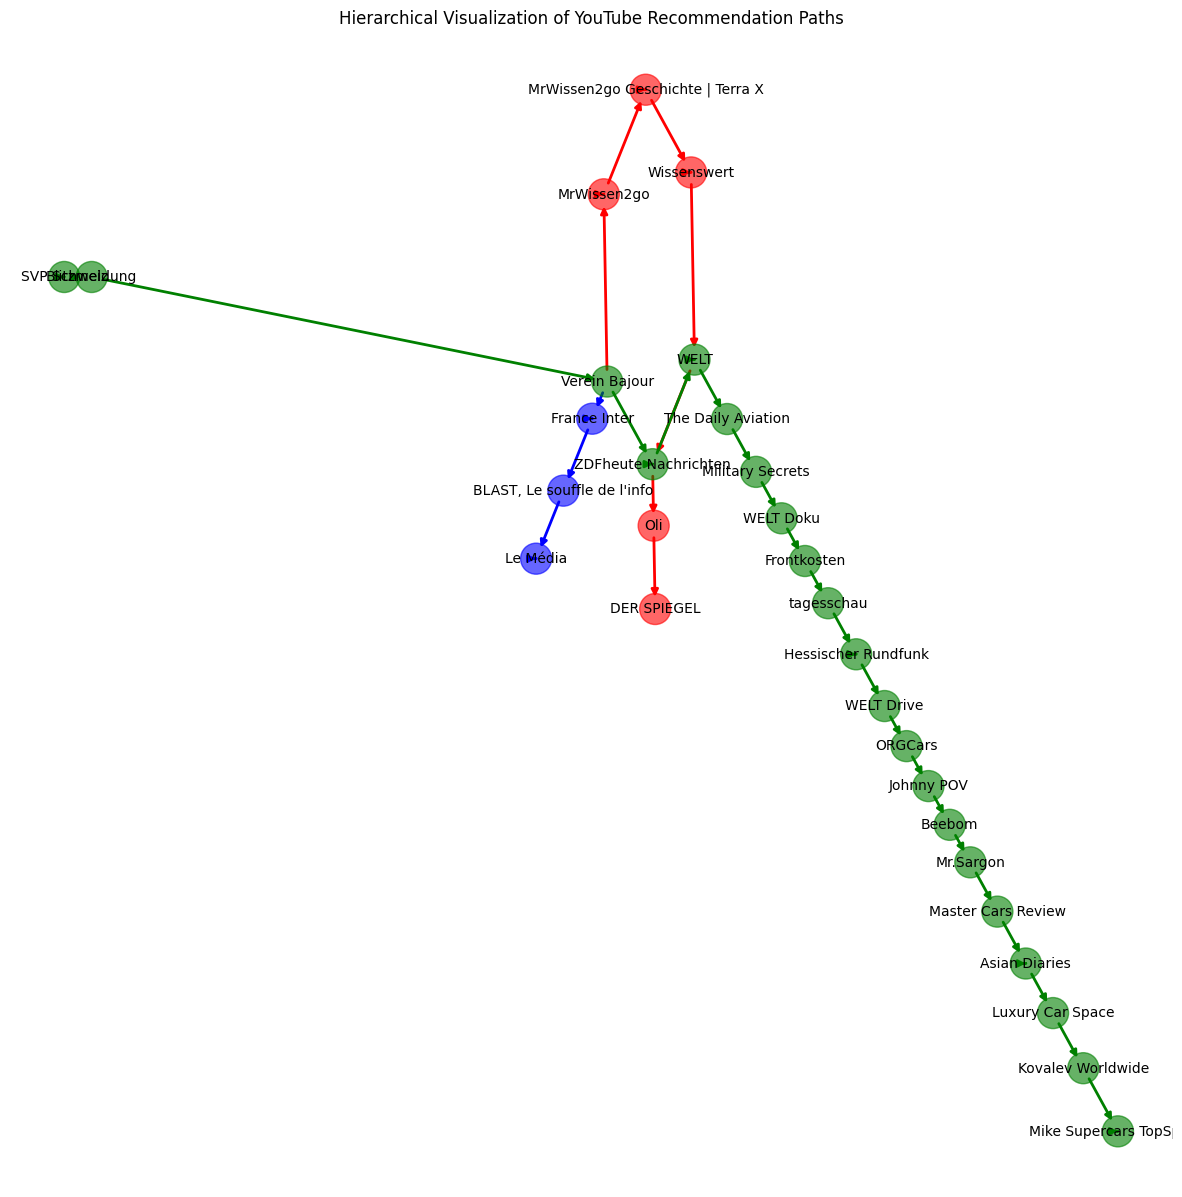

In [113]:
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

# Define the path and the file names
base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/'
runs = ['run55.csv', 'run56.csv', 'run57.csv']

# Create a dictionary to hold the dataframes
dfs = {}

# Load each file into the dictionary
for run in runs:
    run_number = run.split('.')[0]  # Extract the part of the filename without '.csv'
    dfs[run_number] = pd.read_csv(base_path + run)

# Unified graph to hold all data
G = nx.DiGraph()

# Assign different colors to different runs
run_colors = {'run55': 'red', 'run56': 'blue', 'run57': 'green'}  # Colors for different paths
node_colors = {}  # Dictionary to store node colors based on the last path they were part of

# Populate the graph with nodes and edges, assigning colors based on their run
for key, df in dfs.items():
    prev_node = None
    for idx, row in df.iterrows():
        node = row['Channel']
        training = row['Training'] == 'True'  # Assuming this is already boolean or 'True'/'False' string
        if not G.has_node(node):
            G.add_node(node, Training=training)
        # Assign node to the color of the current path if it's the last path this node appears in
        node_colors[node] = run_colors[key]

        if prev_node is not None:
            G.add_edge(prev_node, node, color=run_colors[key])

        prev_node = node

# Apply Graphviz layout
pos = graphviz_layout(G, prog='circo')
#pos = nx.spring_layout(combined_graph, seed= 194)
# Setup plot parameters
plt.figure(figsize=(15, 15))

# Draw nodes with the assigned colors and edges with respective colors
nx.draw_networkx_nodes(G, pos, node_size=500, alpha=0.6, node_color=[node_colors[node] for node in G])
for edge in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist=[(edge[0], edge[1])], width=2, edge_color=edge[2]['color'])

nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('Hierarchical Visualization of YouTube Recommendation Paths')
plt.axis('off')
plt.show()


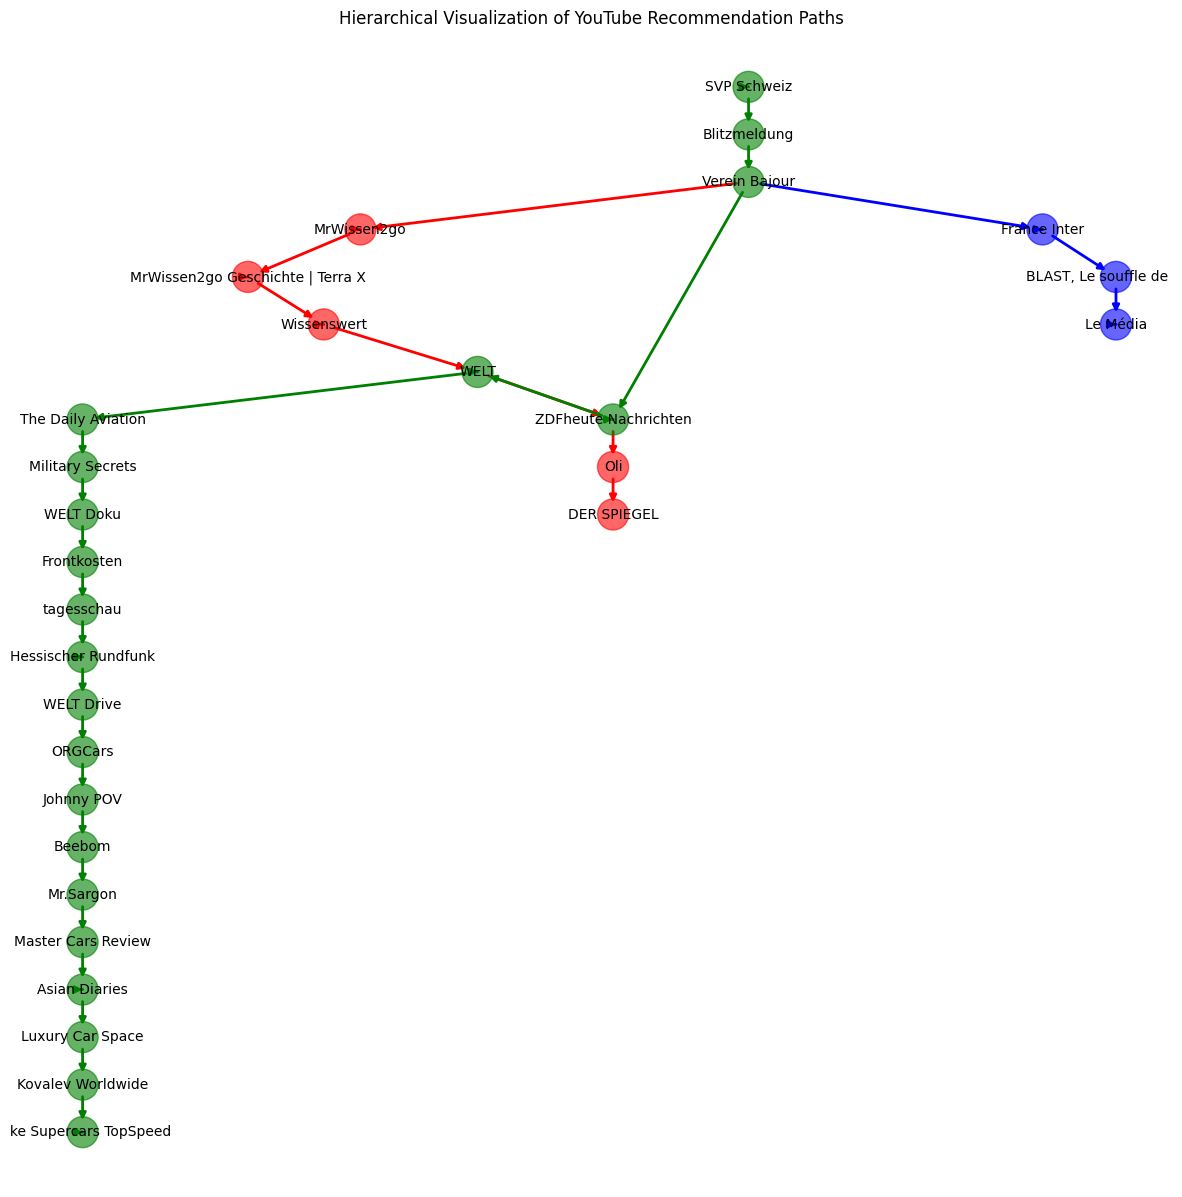

In [47]:
# Unified graph to hold all data
G = nx.DiGraph()

# Assign different colors to different runs
run_colors = {'run55': 'red', 'run56': 'blue', 'run57': 'green'}  # Colors for different paths
node_colors = {}  # Dictionary to store node colors based on the last path they were part of

# Populate the graph with nodes and edges, assigning colors based on their run
for key, df in dfs.items():
    prev_node = None
    for idx, row in df.iterrows():
        node = row['Channel']
        training = row['Training'] == 'True'  # Assuming this is already boolean or 'True'/'False' string
        if not G.has_node(node):
            G.add_node(node, Training=training)
        # Assign node to the color of the current path if it's the last path this node appears in
        node_colors[node] = run_colors[key]

        if prev_node is not None:
            G.add_edge(prev_node, node, color=run_colors[key])

        prev_node = node

# Apply Graphviz layout
pos = graphviz_layout(G, prog='dot')

# Setup plot parameters
plt.figure(figsize=(15, 15))

# Draw nodes with the assigned colors and edges with respective colors
nx.draw_networkx_nodes(G, pos, node_size=500, alpha=0.6, node_color=[node_colors[node] for node in G])
for edge in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist=[(edge[0], edge[1])], width=2, edge_color=edge[2]['color'])

nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('Hierarchical Visualization of YouTube Recommendation Paths')
plt.axis('off')
plt.show()


/home/shutingmi/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: using box for unknown shape o

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


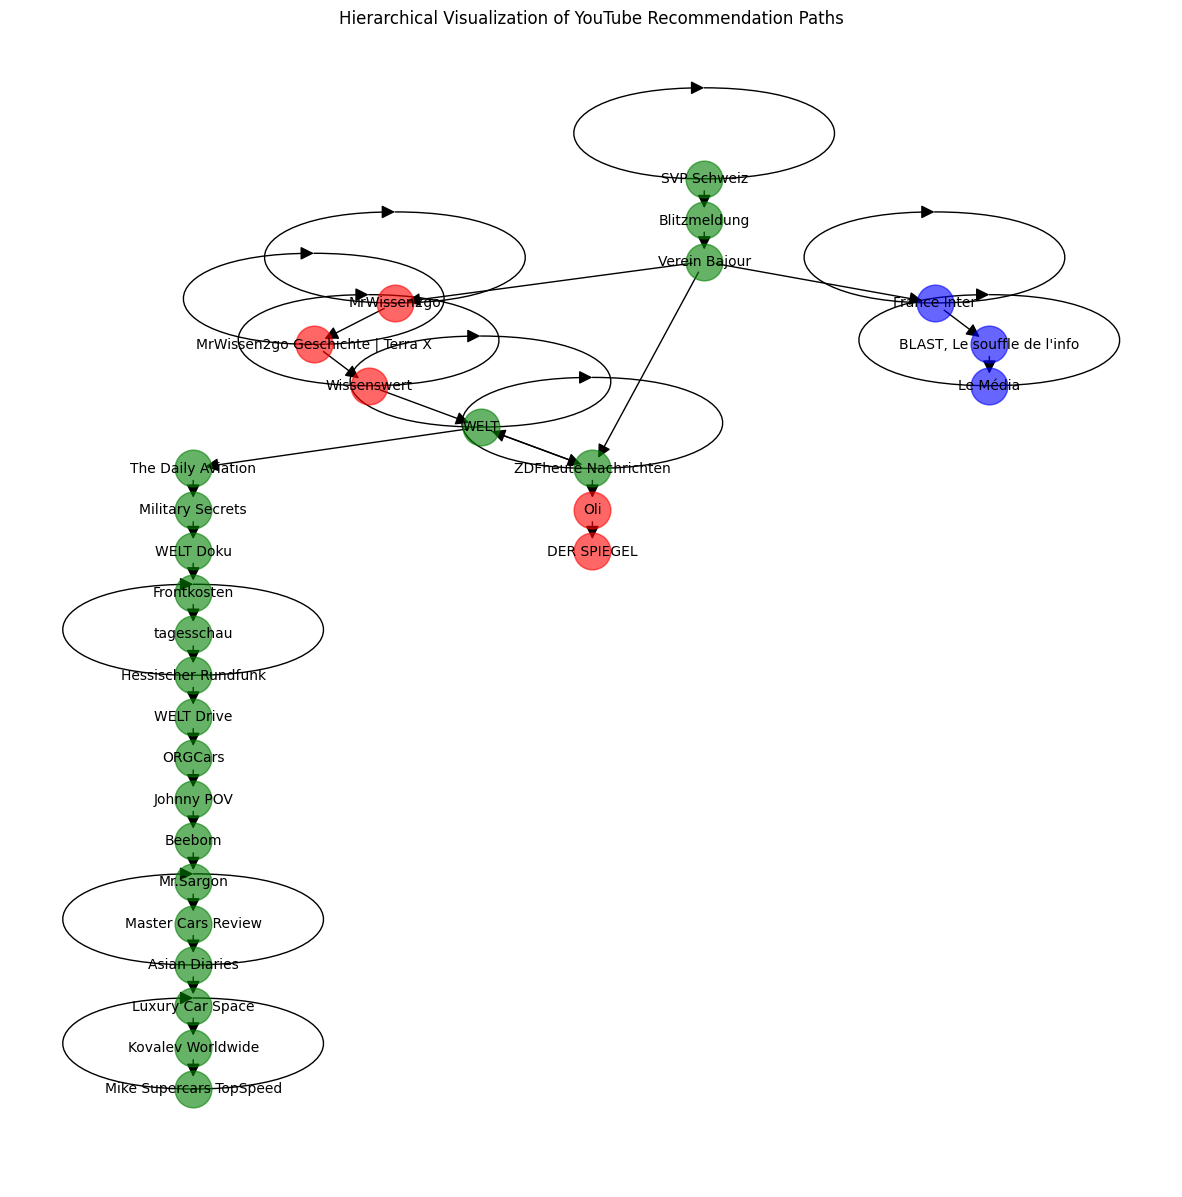

In [48]:
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

# Define the path and the file names
base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/'
runs = ['run55.csv', 'run56.csv', 'run57.csv']

# Create a dictionary to hold the dataframes
dfs = {}

# Load each file into the dictionary
for run in runs:
    run_number = run.split('.')[0]  # Extract the part of the filename without '.csv'
    dfs[run_number] = pd.read_csv(base_path + run)

# Unified graph to hold all data
G = nx.DiGraph()

# Colors for different paths and for root nodes
run_colors = {'run55': 'red', 'run56': 'blue', 'run57': 'green'}  # Colors for different paths
root_color = 'gold'  # Color for root nodes

# Populate the graph with nodes and edges
for key, df in dfs.items():
    prev_node = None
    for idx, row in df.iterrows():
        node = row['Channel']
        training = row['Training'] == 'True'  # Convert string 'True'/'False' to boolean
        if not G.has_node(node):
            G.add_node(node, Training=training)

        # Set the color attribute for the node
        G.nodes[node]['color'] = root_color if training else run_colors[key]
        # Set the shape attribute for the node
        G.nodes[node]['shape'] = 's' if training else 'o'

        if prev_node is not None:
            G.add_edge(prev_node, node)
        prev_node = node

# Apply Graphviz layout
pos = graphviz_layout(G, prog='dot')

# Setup plot parameters
plt.figure(figsize=(15, 15))

# Draw nodes using the color and shape specified in node attributes
for node in G.nodes():
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=G.nodes[node]['color'],
                           node_size=700, alpha=0.6, node_shape=G.nodes[node]['shape'])

nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('Hierarchical Visualization of YouTube Recommendation Paths')
plt.axis('off')
plt.show()



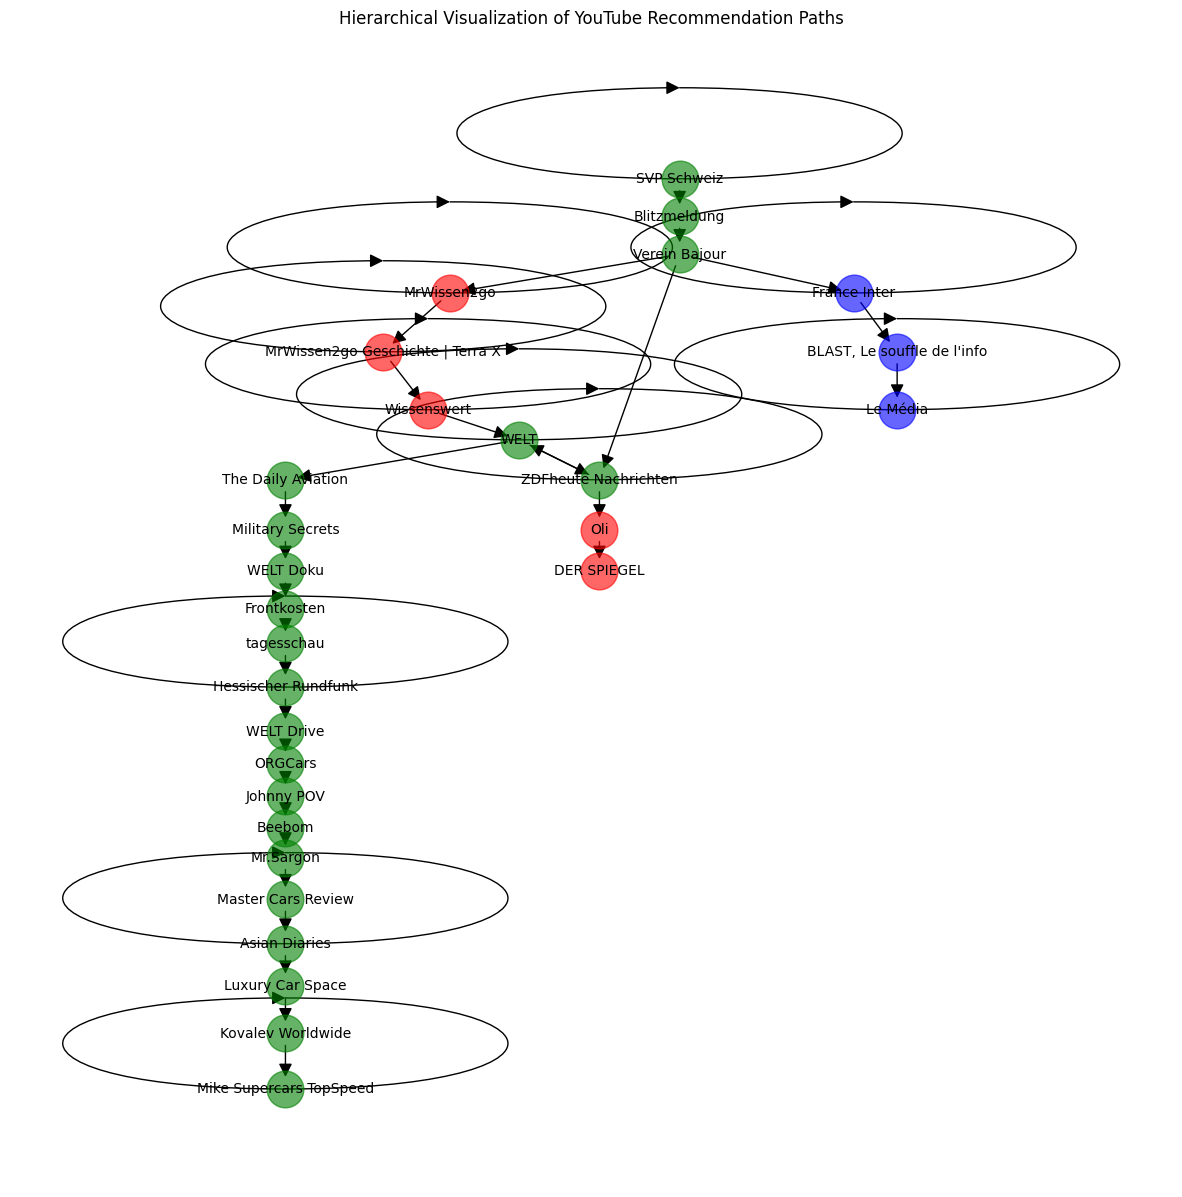

In [50]:
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

# Define the path and the file names
base_path = '/mnt/c/Users/User/Documents/GitHub/ans-project/select_runs/'
runs = ['run55.csv', 'run56.csv', 'run57.csv']

# Create a dictionary to hold the dataframes
dfs = {}

# Load each file into the dictionary
for run in runs:
    run_number = run.split('.')[0]
    dfs[run_number] = pd.read_csv(base_path + run)

# Unified graph to hold all data
G = nx.DiGraph()

# Assign different colors to different paths
run_colors = {'run55': 'red', 'run56': 'blue', 'run57': 'green'}
root_color = 'gold'  # Color for root nodes

# Populate the graph with nodes and edges
for key, df in dfs.items():
    prev_node = None
    for idx, row in df.iterrows():
        node = row['Channel']
        training = row['Training'] == 'True'  # Assuming this is already boolean or 'True'/'False' string
        if not G.has_node(node):
            G.add_node(node, Training=training)

        # Set node attributes
        G.nodes[node]['color'] = root_color if training else run_colors[key]
        G.nodes[node]['shape'] = 'square' if training else 'circle'

        if prev_node is not None:
            G.add_edge(prev_node, node)
        prev_node = node

# Apply Graphviz layout
pos = graphviz_layout(G, prog='dot')

# Setup plot parameters
plt.figure(figsize=(15, 15))

# Draw nodes using the color and shape specified in node attributes
for node in G.nodes():
    shape = 's' if G.nodes[node]['shape'] == 'square' else 'o'
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=G.nodes[node]['color'],
                           node_size=700, alpha=0.6, node_shape=shape)

nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('Hierarchical Visualization of YouTube Recommendation Paths')
plt.axis('off')
plt.show()
